## Libraries

In [ ]:
!pip install shap

In [ ]:
pip install sklearn

In [ ]:
pip install optuna

In [ ]:
# import libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import xgboost as xgb
import shap
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split, KFold

%matplotlib inline
import lightgbm as lgbm
from lightgbm import  log_evaluation, early_stopping
import optuna
from optuna.integration import LightGBMPruningCallback

import pickle

## Data Processing and Feature Selection

For the feature selection, I started off with dropping columns that have low correlation (< 0.4) with SalePrice. I then dropped columns with low variances (< 1). After that I checked the correlation matrix between columns to dropped selected columns that have correlation greater than 0.5 but with consideration for domain knowledge. After that I checked for NAs in the numerical columns. Then, based on the result, I used domain knowledge to fill the NAs with appropriate value. In this case, I used 0 to fill the NAs as it was the most relevant value. As for the categorical NAs, they were replaced with ‘None’. Once, all the NAs were taken cared of, I used LabelEncoder to encode the categorical values. I, then, checked for correlation between columns and dropped them based on domain knowledge.

link to the data: https://drive.google.com/drive/folders/1oml9pTxlzrMBt7qZRe2KSV8dkNkbEXvK?usp=sharing

#### Importing Data

In [ ]:
dataset = pd.read_csv('train.csv')
testset = pd.read_csv('test.csv')

#### Examining train dataset

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

#### Setting y to the label column (numpy array)

In [ ]:
y = dataset['SalePrice'].values
#type(y)

#### Making a new dataframe without SalePrice

In [ ]:
X_start = dataset.drop(['SalePrice'], axis = 1)
X_start.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


#### Checking for columns with low correlation (< 0.4) with SalePrice and dropping them

In [ ]:
price_corr = dataset.corr()['SalePrice']

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


In [ ]:
low_corr = price_corr[abs(price_corr) < 0.4].sort_values(ascending=False)

In [ ]:
low_corr

BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

In [ ]:
for i in low_corr.index:
    X_start.drop(i, axis = 1, inplace = True)
    testset.drop(i, axis = 1, inplace = True)

In [ ]:
X_start.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,2,548,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,2,460,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,2,608,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,3,642,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,3,836,TA,TA,Y,NaN,NaN,NaN,WD,Normal


#### Checking for columns with low variance (< 1) and dropping them

In [ ]:
variance = X_start.var()

The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.


In [ ]:
low_var = variance[(variance) < 1].sort_values(ascending = True)

In [ ]:
low_var

FullBath      0.303508
Fireplaces    0.415595
GarageCars    0.558480
dtype: float64

In [ ]:
for i in low_var.index:
    X_start.drop(i, axis = 1, inplace = True)
    testset.drop(i, axis = 1, inplace = True)

In [ ]:
X_start.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageFinish,GarageArea,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,RFn,548,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,RFn,460,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,RFn,608,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Unf,642,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,RFn,836,TA,TA,Y,NaN,NaN,NaN,WD,Normal


#### Checking to correlation between columns and dropping selected columns based on domain knowledge

In [ ]:
correlation = X_start.corr().abs()
corr_list = (correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(bool))
            .stack())
high_corr = corr_list.loc[corr_list > 0.5]

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


In [ ]:
high_corr

OverallQual   YearBuilt       0.572323
              YearRemodAdd    0.550684
              TotalBsmtSF     0.537808
              GrLivArea       0.593007
              GarageYrBlt     0.547766
              GarageArea      0.562022
YearBuilt     YearRemodAdd    0.592855
              GarageYrBlt     0.825667
YearRemodAdd  GarageYrBlt     0.642277
TotalBsmtSF   1stFlrSF        0.819530
1stFlrSF      GrLivArea       0.566024
GrLivArea     TotRmsAbvGrd    0.825489
GarageYrBlt   GarageArea      0.564567
dtype: float64

In [ ]:
drop_hico = ['GarageArea', 'TotRmsAbvGrd', '1stFlrSF', 'GarageYrBlt', 'YearRemodAdd']

In [ ]:
X_start = X_start.drop(drop_hico, axis = 1)
testset = testset.drop(drop_hico, axis = 1)

In [ ]:
X_start.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


#### Identifiying numerical and categorical values for replacing NAs with appropriate values

In [ ]:
numerical = X_start.select_dtypes(include=['number'])
categorical = X_start.select_dtypes(include=['object'])
t_numerical = testset.select_dtypes(include=['number'])
t_categorical = testset.select_dtypes(include=['object'])

In [ ]:
numerical.head()

,OverallQual,YearBuilt,MasVnrArea,TotalBsmtSF,GrLivArea
0,7,2003,196.0,856,1710
1,6,1976,0.0,1262,1262
2,7,2001,162.0,920,1786
3,7,1915,0.0,756,1717
4,8,2000,350.0,1145,2198


In [ ]:
categorical

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [ ]:
num_na = numerical.columns[numerical.isnull().any()]
num_na

Index(['MasVnrArea'], dtype='object')

#### Based on domain knowledge, NAs in MasVrArea is replaced with 0

In [ ]:
for n in [num_na]:
    X_start[n] = X_start[n].fillna(0)

In [ ]:
t_num_na = t_numerical.columns[t_numerical.isnull().any()]
t_num_na

Index(['MasVnrArea', 'TotalBsmtSF'], dtype='object')

In [ ]:
for n in [t_num_na]:
    testset[n] = testset[n].fillna(0)

In [ ]:
categorical.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


#### For categorical NAs, they were replaced with None

In [ ]:
cat_na = categorical.columns[categorical.isnull().any()]
cat_na

Index(['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
       'Fence', 'MiscFeature'],
      dtype='object')

In [ ]:
for c in [cat_na]:
    X_start[c] = X_start[c].fillna('None')
    categorical[c] = categorical[c].fillna('None')

In [ ]:
t_cat_na = t_categorical.columns[t_categorical.isnull().any()]
t_cat_na

Index(['MSZoning', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType'],
      dtype='object')

In [ ]:
for c in [t_cat_na]:
    testset[c] = testset[c].fillna('None')
    t_categorical[c] = t_categorical[c].fillna('None')

In [ ]:
categorical.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
1,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
2,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
3,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,None,None,None,WD,Abnorml
4,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal


#### Checking to see if they are any NAs left

In [ ]:
X_start.isnull().values.any()

False

In [ ]:
testset.isnull().values.any()

False

#### Label encoding of categorical data

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feature in categorical.columns:
    X_start[feature]=le.fit_transform(X_start[feature])
    categorical[feature]=le.fit_transform(categorical[feature])
    testset[feature]=le.fit_transform(testset[feature])
    t_categorical[feature]=le.fit_transform(t_categorical[feature])

In [ ]:
categorical.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,3,1,1,3,3,0,4,0,5,2,...,1,2,5,5,2,3,4,1,8,4
1,3,1,1,3,3,0,2,0,24,1,...,1,2,5,5,2,3,4,1,8,4
2,3,1,1,0,3,0,4,0,5,2,...,1,2,5,5,2,3,4,1,8,4
3,3,1,1,0,3,0,0,0,6,2,...,5,3,5,5,2,3,4,1,8,0
4,3,1,1,0,3,0,2,0,15,2,...,1,2,5,5,2,3,4,1,8,4


#### Checking for correlation between categorial columns and dropping highly correlated items based on domain knowledge

In [ ]:
cat_corr = categorical.corr().abs()
cat_corr_list = (cat_corr.where(np.triu(np.ones(cat_corr.shape), k=1).astype(bool))
            .stack())
high_cat_corr = cat_corr_list.loc[cat_corr_list > 0.5]

In [ ]:
high_cat_corr

Exterior1st  Exterior2nd    0.854163
ExterQual    BsmtQual       0.572327
             KitchenQual    0.641584
GarageQual   GarageCond     0.618383
dtype: float64

In [ ]:
drop_hcc = ['GarageCond', 'BsmtQual', 'KitchenQual', 'Exterior2nd']

In [ ]:
X_start = X_start.drop(drop_hcc, axis = 1)
testset = testset.drop(drop_hcc, axis = 1)

In [ ]:
X_start.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,FireplaceQu,GarageType,GarageFinish,GarageQual,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,3,1,1,3,3,0,4,0,5,2,...,3,1,2,5,2,3,4,1,8,4
1,3,1,1,3,3,0,2,0,24,1,...,5,1,2,5,2,3,4,1,8,4
2,3,1,1,0,3,0,4,0,5,2,...,5,1,2,5,2,3,4,1,8,4
3,3,1,1,0,3,0,0,0,6,2,...,2,5,3,5,2,3,4,1,8,0
4,3,1,1,0,3,0,2,0,15,2,...,5,1,2,5,2,3,4,1,8,4


#### Normalizing data

In [ ]:
X_start = (X_start - X_start.min()) / (X_start.max() - X_start.min())
testset = (testset - testset.min()) / (testset.max() - testset.min())

In [ ]:
dataset.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Using Decision Tree (Random Forest) to selected the 10 best features

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=1, max_depth=10)
model.fit(X_start,y)

RandomForestRegressor(max_depth=10, random_state=1)

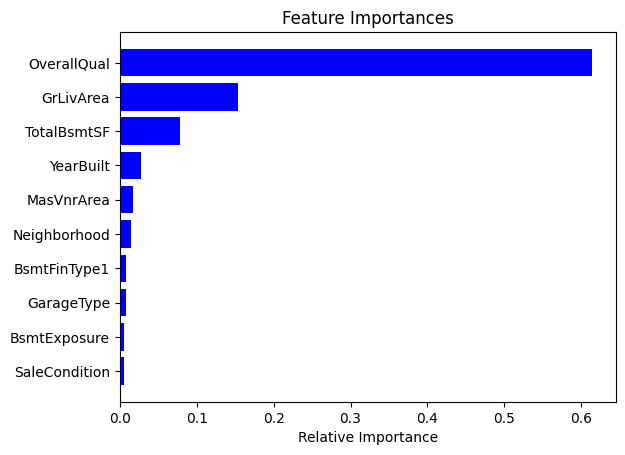

In [ ]:
features = X_start.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
feat = dict(reversed(sorted(zip(model.feature_importances_, X_start.columns.values))))

In [ ]:
feat10 = [feat[x] for x in list(feat)[:10]]

In [ ]:
t_drop = [feat[x] for x in list(feat)[10:]]

In [ ]:
for i in t_drop:
    testset.drop(i, axis = 1, inplace = True)

In [ ]:
testset.shape

(1459, 10)

In [ ]:
X = X_start[feat10].copy()

In [ ]:
X.head()

,OverallQual,GrLivArea,TotalBsmtSF,YearBuilt,MasVnrArea,Neighborhood,BsmtFinType1,GarageType,BsmtExposure,SaleCondition
0,0.666667,0.259231,0.140098,0.949275,0.12250,0.208333,0.333333,0.166667,0.75,0.8
1,0.555556,0.174830,0.206547,0.753623,0.00000,1.000000,0.000000,0.166667,0.25,0.8
2,0.666667,0.273549,0.150573,0.934783,0.10125,0.208333,0.333333,0.166667,0.50,0.8
3,0.666667,0.260550,0.123732,0.311594,0.00000,0.250000,0.000000,0.833333,0.75,0.0
4,0.777778,0.351168,0.187398,0.927536,0.21875,0.625000,0.333333,0.166667,0.00,0.8


In [ ]:
y

array([208500, 181500, 223500, ..., 266500, 142125, 147500])

#### Spiliting the training data for testing purposes

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### Getting the categorical features

In [ ]:
categorical_features = []
for col in X.columns:
    if X[col].dtype == "object":
        categorical_features.append(col)

In [ ]:
# Cat feature indices on X
cat_indices = []
for c in categorical_features:
    if c in X.columns:
        idx = list(X.columns).index(c)
        cat_indices.append(idx)

##XGBoost Model

In [ ]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror",max_depth=3)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

#### testing the model

In [ ]:
xgbt_pred = xgb_model.predict(X_test)
print("MAE test score:", int(mean_absolute_error(y_test, xgbt_pred)))
print("MSE test score:", int(mean_squared_error(y_test, xgbt_pred)))
print("RMSE test score:", int(sqrt(mean_squared_error(y_test, xgbt_pred))))

MAE test score: 18490
MSE test score: 840217398
RMSE test score: 28986


In [ ]:
y_test.mean()

181370.38356164383

Discussion: Mean absoute error and (root) mean square error difference between the predicted price and the ground truth are shown to show how the model performs.

## SHAP for XGBoost

In [ ]:
explainer = shap.TreeExplainer(xgb_model)
shap_interaction = explainer.shap_interaction_values(X_train)
# Get SHAP values
shap_values = explainer(X_train)

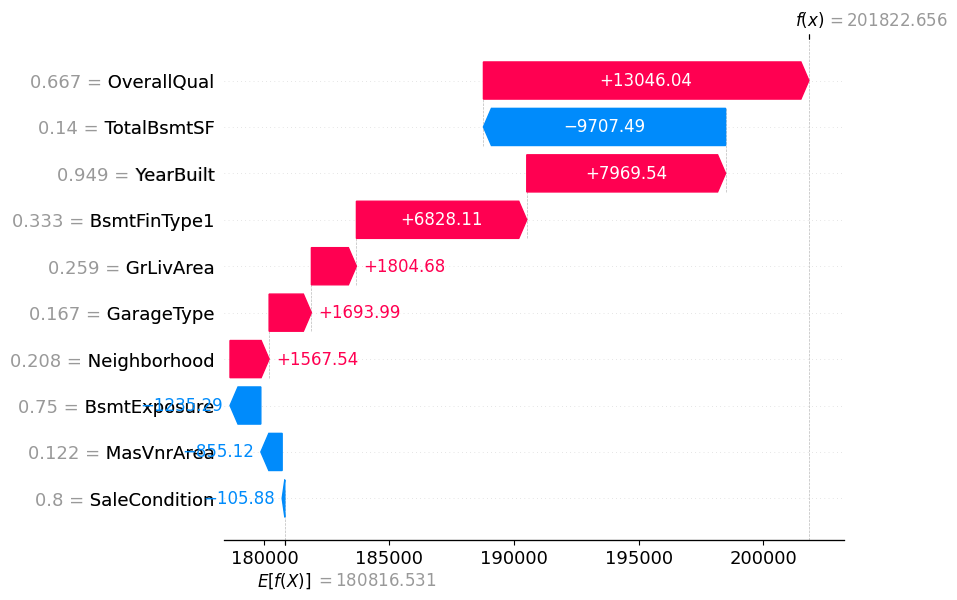

In [ ]:
# Waterfall plot for first observation
shap.plots.waterfall(shap_values[0])

**Discussion**

This waterfall plot shows which feature contributes how much to the predicted price. The Overall Quality has the highest attribution to the predicted price in this model, followed by Year Built, Total Basement Squre Foot, etc. But the Masonry veneer type and Basement Exposure, which refers to walkout or garden level walls, reduces the predicted price.

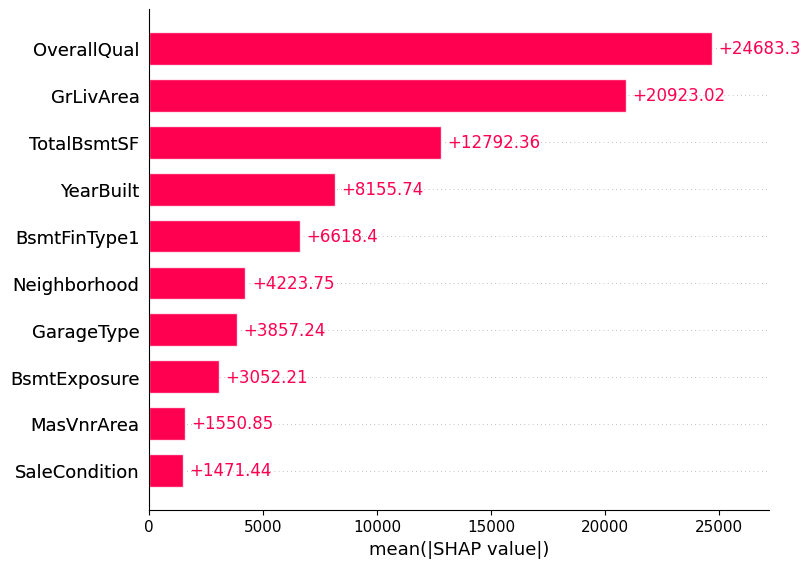

In [ ]:
#Mean SHAP
shap.plots.bar(shap_values)

**Discussion**

This mean SHAP value plot tells us which features are the most important by find the mean values across all observations instead of positive and negative offsets. You can see from the above plot that Overall Quality, Above grade (ground) living area square feet, and Total square feet of basement area made the most significant impact on the model’s predictions.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


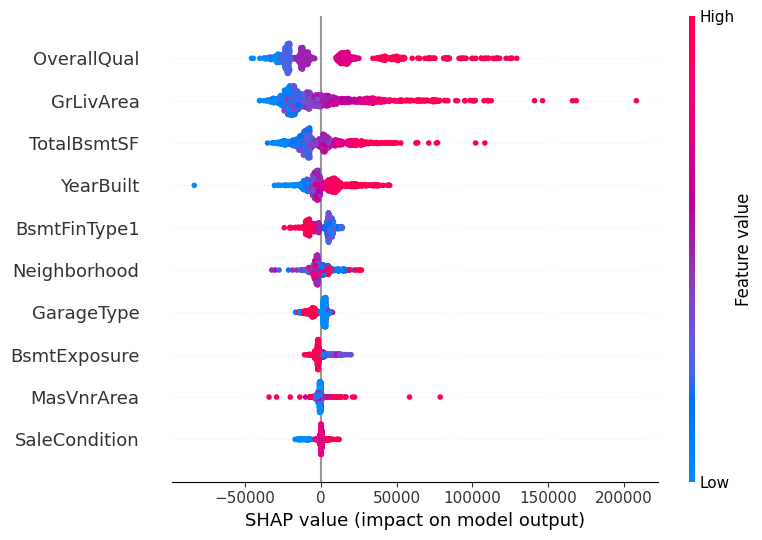

In [ ]:
#Display summary plot
shap.summary_plot(shap_values, X_train)

**Discussion**

This summary plot visualises all of the SHAP values. On the y-axis, the values are grouped by feature and higher feature values are redder. This plot highlights important relationships: for example, for the Overall Quality and Above grade (ground) living area square feet, as the feature value increases the SHAP values increase. But for the Basement Exposure, which refers to walkout or garden level walls, has the opposite relationship.
From these Beeswarm plots, we can also see where the high density SHAP values are because the points are vertically stacked.

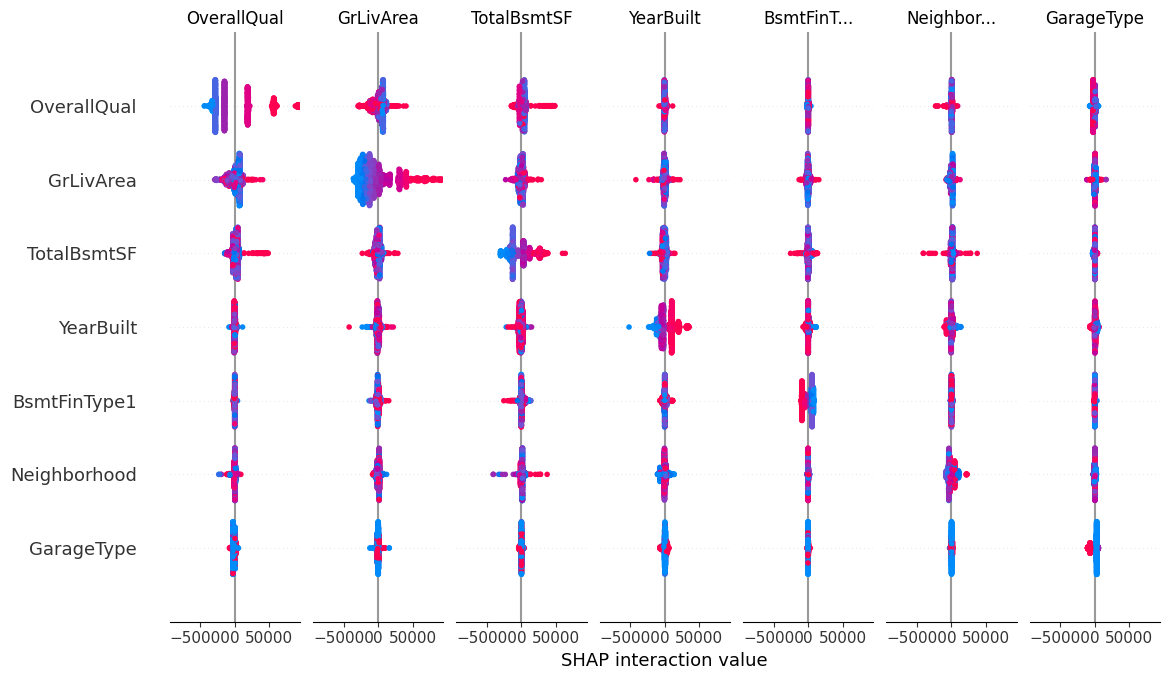

In [ ]:
#Display summary plot
shap.summary_plot(shap_interaction, X_train)

**Discussion**

This summary plot gives additional insight through visualizing the relationship between features and their SHAP interaction values. As we can see, certain features tend to have a more significiant impact on the prediction, and the distributions of the plots tell us which interactions are more significant than others. For example, Overall Quality, Above Ground Living Area, Total Basement Square Foot, and Neighborhood.

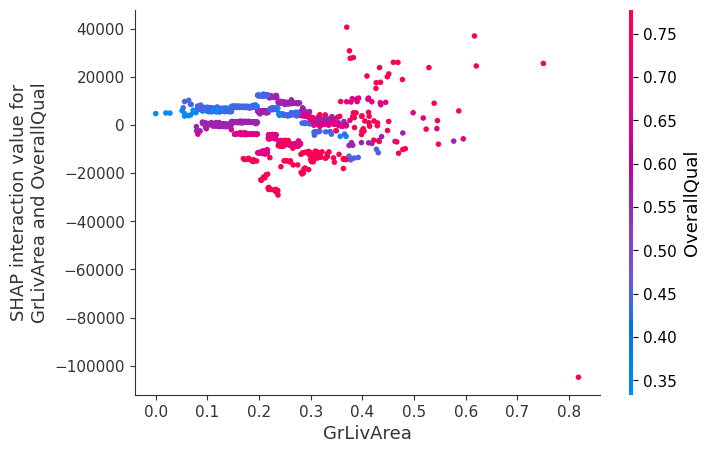

In [ ]:
# OverallQual-GrLivArea depenence plot
shap.dependence_plot(
    ("GrLivArea", "OverallQual"),
    shap_interaction, X_train,
    display_features = X_train)

**Discussion**

Given a relatively high overall quality, bigger above ground living area increase the SHAP interaction value. However, when the overall quality of the home is low or medium, change in SHAP interaction value is not as pronounced.

##Light Gradient Boosting Machine (LGBM) (Baseline)

This is the Baseline.

In [ ]:
reg_lgbm_baseline = lgbm.LGBMRegressor()  # default - 'regression'

In [ ]:
reg_lgbm_baseline.fit(X_train, y_train)

LGBMRegressor()

In [ ]:
lgbm_predict = reg_lgbm_baseline.predict(X_test)

In [ ]:
print("MAE test score:", int(mean_absolute_error(y_test, lgbm_predict)))
print("MSE test score:", int(mean_squared_error(y_test, lgbm_predict)))
print("RMSE test score:", int(sqrt(mean_squared_error(y_test, lgbm_predict))))

MAE test score: 11459
MSE test score: 688212425
RMSE test score: 26233


In [ ]:
y_test.mean()

181370.38356164383

**Discussion:**

I did XGBoost for milestone-2 and switch to LGBMRegressor for milestone-3 and the baseline model is already better than the XGBoost, with RMSE = 26233.

###SHAP for LGBM baseline

In [ ]:
explainer_lgbm_baseline = shap.TreeExplainer(reg_lgbm_baseline)
shap_interaction_lgbm_baseline = explainer_lgbm_baseline.shap_interaction_values(X_train)
# Get SHAP values
shap_values_lgbm_baseline = explainer_lgbm_baseline(X_train)

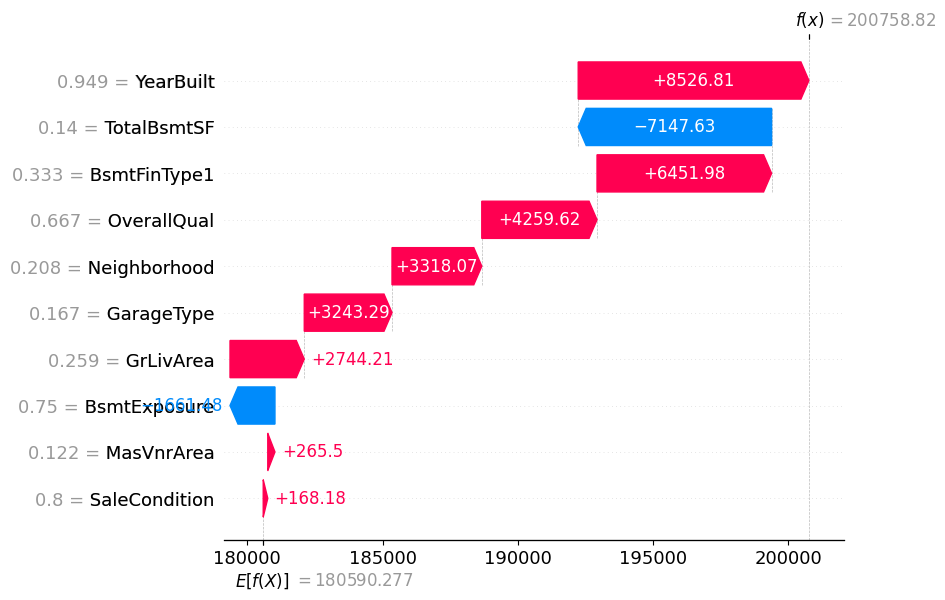

In [ ]:
# Waterfall plot for first observation
shap.plots.waterfall(shap_values_lgbm_baseline[0])

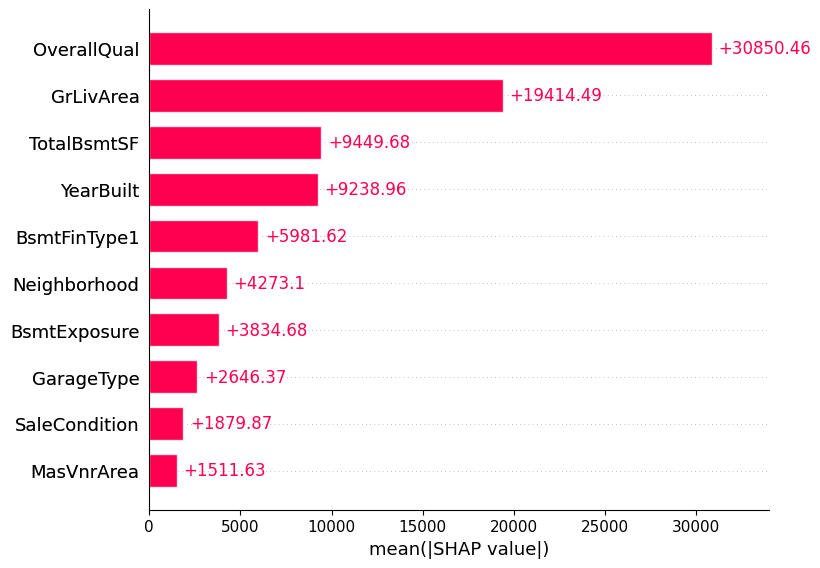

In [ ]:
#Mean SHAP
shap.plots.bar(shap_values_lgbm_baseline)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


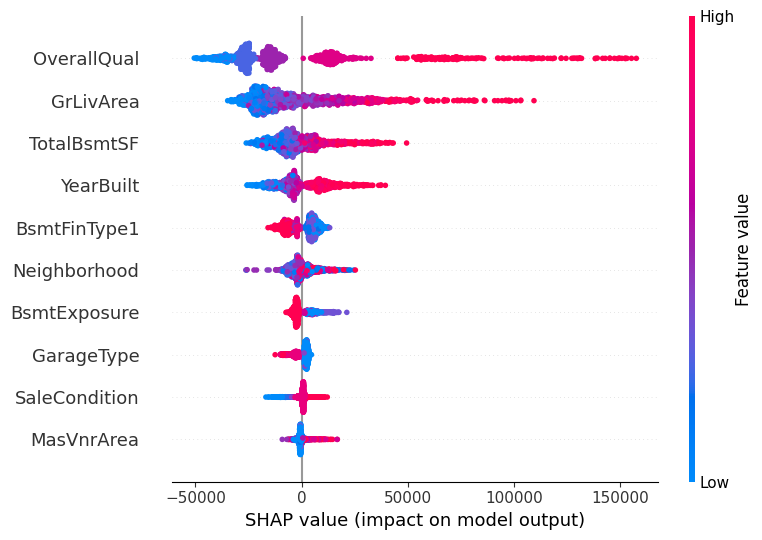

In [ ]:
#Display summary plot
shap.summary_plot(shap_values_lgbm_baseline, X_train)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


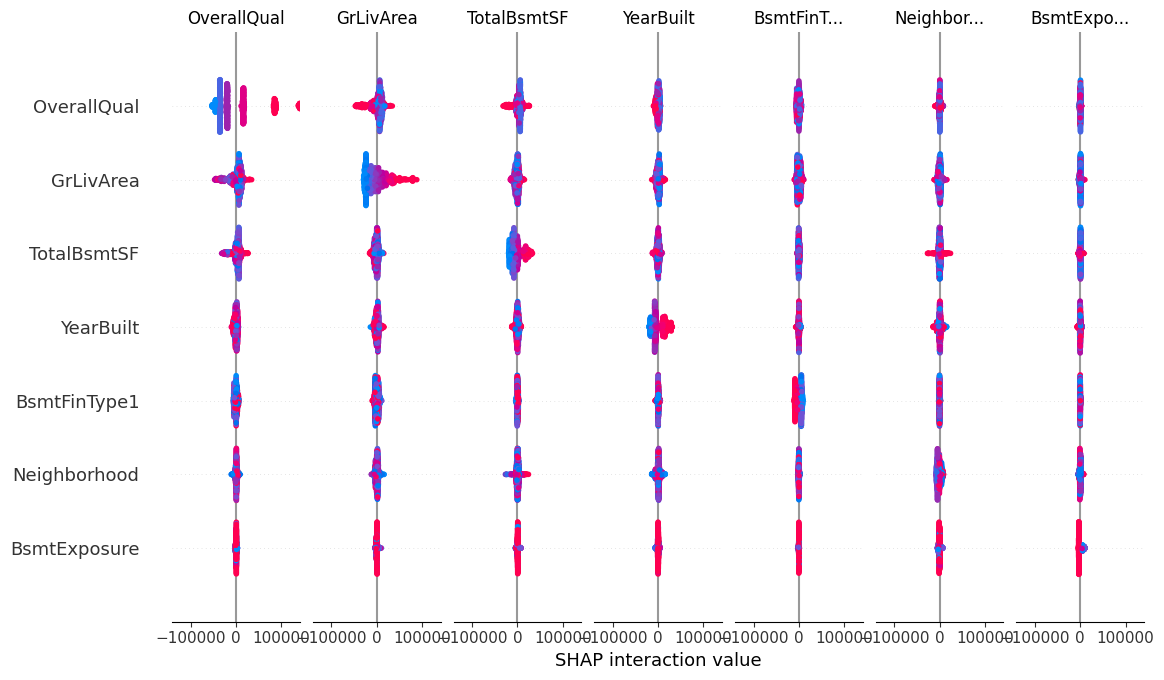

In [ ]:
#Display summary plot
shap.summary_plot(shap_interaction_lgbm_baseline, X_train)

##Tuning with Optuna

In [ ]:
def objective(trial, data=X,target=y):

    params = {
                'metric': 'rmse',
                'random_state': 22,
                'n_estimators': 20000,
                'boosting_type': trial.suggest_categorical("boosting_type", ["gbdt", "goss"]),
                'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
                'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
                'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
                'subsample': trial.suggest_categorical('subsample', [0.6, 0.7, 0.85, 1.0]),
                'learning_rate': trial.suggest_categorical('learning_rate', [0.005, 0.01, 0.02, 0.03, 0.05, 0.1]),
                'max_depth': trial.suggest_int('max_depth', 2, 12, step=1),
                'num_leaves' : trial.suggest_int('num_leaves', 13, 148, step=5),
                'min_child_samples': trial.suggest_int('min_child_samples', 1, 96, step=5),
            }
    reg = lgbm.LGBMRegressor(**params)
    reg.fit(X_train ,y_train,
            eval_set=[(X_test, y_test)],
            #categorical_feature=cat_indices,
            callbacks=[log_evaluation(period=1000),
                       early_stopping(stopping_rounds=50)
                      ],
           )

    y_pred = reg.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    return rmse

In [ ]:
params_search = True
# # Optuna: run study trials

if params_search:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=120)

[I 2023-07-22 03:58:15,987] A new study created in memory with name: no-name-7ee8cb69-df61-422c-a7a1-1222587d226f
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 34610.7
[2000]	valid_0's rmse: 33190.5
Early stopping, best iteration is:
[2603]	valid_0's rmse: 32526


[I 2023-07-22 03:58:17,275] Trial 0 finished with value: 32525.95127113584 and parameters: {'boosting_type': 'goss', 'reg_alpha': 3.564753421299634, 'reg_lambda': 6.127269055702681, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 2, 'num_leaves': 23, 'min_child_samples': 26}. Best is trial 0 with value: 32525.95127113584.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 25145.9
[2000]	valid_0's rmse: 21710.9
[3000]	valid_0's rmse: 19783
[4000]	valid_0's rmse: 18562
[5000]	valid_0's rmse: 17771.3
[6000]	valid_0's rmse: 17359
[7000]	valid_0's rmse: 17046.3
[8000]	valid_0's rmse: 16821.6
Early stopping, best iteration is:
[8445]	valid_0's rmse: 16733.7


[I 2023-07-22 03:58:25,109] Trial 1 finished with value: 16733.697042790067 and parameters: {'boosting_type': 'goss', 'reg_alpha': 1.0792484856047635, 'reg_lambda': 0.5511270098802705, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 103, 'min_child_samples': 11}. Best is trial 1 with value: 16733.697042790067.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 34059.3
[2000]	valid_0's rmse: 32055.6
[3000]	valid_0's rmse: 30689.2
[4000]	valid_0's rmse: 29559.7
[5000]	valid_0's rmse: 28638.6
[6000]	valid_0's rmse: 27908.7
[7000]	valid_0's rmse: 27325.4
[8000]	valid_0's rmse: 26800.2
[9000]	valid_0's rmse: 26388.4
[10000]	valid_0's rmse: 25927.8
[11000]	valid_0's rmse: 25444.2
[12000]	valid_0's rmse: 25029.6
[13000]	valid_0's rmse: 24661.2
[14000]	valid_0's rmse: 24363.7
[15000]	valid_0's rmse: 24068.2
[16000]	valid_0's rmse: 23800.9
[17000]	valid_0's rmse: 23570.2
[18000]	valid_0's rmse: 23287.1
[19000]	valid_0's rmse: 23046.3
[20000]	valid_0's rmse: 22861.9
Did not meet early stopping. Best iteration is:
[20000]	valid_0's rmse: 22861.9


[I 2023-07-22 03:58:36,504] Trial 2 finished with value: 22861.947255775216 and parameters: {'boosting_type': 'gbdt', 'reg_alpha': 2.143484619426666, 'reg_lambda': 0.017296058368244424, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.005, 'max_depth': 8, 'num_leaves': 58, 'min_child_samples': 46}. Best is trial 1 with value: 16733.697042790067.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 26981.3
[2000]	valid_0's rmse: 24377.5
[3000]	valid_0's rmse: 22819.4
Early stopping, best iteration is:
[3255]	valid_0's rmse: 22476.7


[I 2023-07-22 03:58:38,064] Trial 3 finished with value: 22476.68720082341 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.04114065600099953, 'reg_lambda': 0.277067753964267, 'colsample_bytree': 0.8, 'subsample': 0.85, 'learning_rate': 0.05, 'max_depth': 6, 'num_leaves': 98, 'min_child_samples': 26}. Best is trial 1 with value: 16733.697042790067.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 40013.3
[2000]	valid_0's rmse: 38498.5
[3000]	valid_0's rmse: 37592.1
[4000]	valid_0's rmse: 37016.1
[5000]	valid_0's rmse: 36514.2
[6000]	valid_0's rmse: 36151.6
[7000]	valid_0's rmse: 35852.2
[8000]	valid_0's rmse: 35624.6
[9000]	valid_0's rmse: 35413.3
[10000]	valid_0's rmse: 35224.7
[11000]	valid_0's rmse: 35062.9
[12000]	valid_0's rmse: 34888.4
Early stopping, best iteration is:
[12818]	valid_0's rmse: 34759.4


[I 2023-07-22 03:58:42,554] Trial 4 finished with value: 34759.43082616638 and parameters: {'boosting_type': 'goss', 'reg_alpha': 1.5679052633045572, 'reg_lambda': 0.009644831124326583, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.005, 'max_depth': 12, 'num_leaves': 13, 'min_child_samples': 71}. Best is trial 1 with value: 16733.697042790067.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 30429.9
[2000]	valid_0's rmse: 27934.8
[3000]	valid_0's rmse: 26173.2
[4000]	valid_0's rmse: 25045.4
[5000]	valid_0's rmse: 23950.2
[6000]	valid_0's rmse: 22852.7
[7000]	valid_0's rmse: 22188.7
Early stopping, best iteration is:
[7891]	valid_0's rmse: 21615.9


[I 2023-07-22 03:58:47,747] Trial 5 finished with value: 21615.910899622057 and parameters: {'boosting_type': 'gbdt', 'reg_alpha': 7.566372450248474, 'reg_lambda': 0.006372790886012054, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.005, 'max_depth': 5, 'num_leaves': 53, 'min_child_samples': 16}. Best is trial 1 with value: 16733.697042790067.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 31543.5
Early stopping, best iteration is:
[1671]	valid_0's rmse: 30192.5


[I 2023-07-22 03:58:48,358] Trial 6 finished with value: 30192.489818872462 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.0032475876290340047, 'reg_lambda': 0.005315941039419465, 'colsample_bytree': 0.8, 'subsample': 0.85, 'learning_rate': 0.05, 'max_depth': 4, 'num_leaves': 13, 'min_child_samples': 41}. Best is trial 1 with value: 16733.697042790067.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 39331.7


[I 2023-07-22 03:58:48,848] Trial 7 finished with value: 37895.06702403795 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.028730033286312403, 'reg_lambda': 0.06634074375782298, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 8, 'num_leaves': 83, 'min_child_samples': 96}. Best is trial 1 with value: 16733.697042790067.


Early stopping, best iteration is:
[1944]	valid_0's rmse: 37895.1
Training until validation scores don't improve for 50 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[1000]	valid_0's rmse: 20902.5
[2000]	valid_0's rmse: 17835.2
[3000]	valid_0's rmse: 16501.1
[4000]	valid_0's rmse: 15968
[5000]	valid_0's rmse: 15770.4
Early stopping, best iteration is:
[4988]	valid_0's rmse: 15768


[I 2023-07-22 03:58:55,568] Trial 8 finished with value: 15767.962510758935 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.0038310691556454795, 'reg_lambda': 2.045898765281297, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 11, 'num_leaves': 103, 'min_child_samples': 6}. Best is trial 8 with value: 15767.962510758935.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 33672.8
[2000]	valid_0's rmse: 32105.8
[3000]	valid_0's rmse: 31077.5
[4000]	valid_0's rmse: 30285.2
[5000]	valid_0's rmse: 29544.5
[6000]	valid_0's rmse: 28768.6
[7000]	valid_0's rmse: 28018.8
[8000]	valid_0's rmse: 27413.8
[9000]	valid_0's rmse: 26952.9
[10000]	valid_0's rmse: 26581.4
[11000]	valid_0's rmse: 26234.8
[12000]	valid_0's rmse: 25655
[13000]	valid_0's rmse: 25297.9
[14000]	valid_0's rmse: 24870.1
[15000]	valid_0's rmse: 24305.2
Early stopping, best iteration is:
[15629]	valid_0's rmse: 24116.4


[I 2023-07-22 03:59:02,074] Trial 9 finished with value: 24116.355391728423 and parameters: {'boosting_type': 'gbdt', 'reg_alpha': 0.14139812256617787, 'reg_lambda': 0.07456234059519377, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.005, 'max_depth': 4, 'num_leaves': 28, 'min_child_samples': 31}. Best is trial 8 with value: 15767.962510758935.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 34233.2
[2000]	valid_0's rmse: 32326
[3000]	valid_0's rmse: 31048.3
[4000]	valid_0's rmse: 29858.8
[5000]	valid_0's rmse: 29031.8
[6000]	valid_0's rmse: 28312.3
[7000]	valid_0's rmse: 27746.5
[8000]	valid_0's rmse: 27275.8
[9000]	valid_0's rmse: 26762.5
[10000]	valid_0's rmse: 26350.1
[11000]	valid_0's rmse: 26031.7
[12000]	valid_0's rmse: 25669.7
[13000]	valid_0's rmse: 25430.8
[14000]	valid_0's rmse: 25132.7
[15000]	valid_0's rmse: 24856.6
[16000]	valid_0's rmse: 24622.4
[17000]	valid_0's rmse: 24432.1
[18000]	valid_0's rmse: 24266
Early stopping, best iteration is:
[18186]	valid_0's rmse: 24234.2


[I 2023-07-22 03:59:13,266] Trial 10 finished with value: 24234.182975557454 and parameters: {'boosting_type': 'gbdt', 'reg_alpha': 0.001972076419062882, 'reg_lambda': 9.280577705471206, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 12, 'num_leaves': 143, 'min_child_samples': 66}. Best is trial 8 with value: 15767.962510758935.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 15972.4
Early stopping, best iteration is:
[1869]	valid_0's rmse: 15583.9


[I 2023-07-22 03:59:17,524] Trial 11 finished with value: 15583.874488583177 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.35636332930573894, 'reg_lambda': 1.143511745084067, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 118, 'min_child_samples': 1}. Best is trial 11 with value: 15583.874488583177.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 14271.9
[2000]	valid_0's rmse: 13714.9
Early stopping, best iteration is:
[2215]	valid_0's rmse: 13700.5


[I 2023-07-22 03:59:22,966] Trial 12 finished with value: 13700.511683372875 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.2777676675717941, 'reg_lambda': 1.500203026036375, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 128, 'min_child_samples': 1}. Best is trial 12 with value: 13700.511683372875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[842]	valid_0's rmse: 17099.2


[I 2023-07-22 03:59:25,318] Trial 13 finished with value: 17099.22660266075 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.351202305860911, 'reg_lambda': 1.2976656556731612, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.03, 'max_depth': 9, 'num_leaves': 138, 'min_child_samples': 1}. Best is trial 12 with value: 13700.511683372875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[283]	valid_0's rmse: 17121.5


[I 2023-07-22 03:59:26,288] Trial 14 finished with value: 17121.451607792624 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.3692059645367899, 'reg_lambda': 0.3584159615961434, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'num_leaves': 123, 'min_child_samples': 1}. Best is trial 12 with value: 13700.511683372875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 37068
[2000]	valid_0's rmse: 35506.6
[3000]	valid_0's rmse: 34741.9
[4000]	valid_0's rmse: 34198.2
Early stopping, best iteration is:
[4882]	valid_0's rmse: 33763.5


[I 2023-07-22 03:59:27,946] Trial 15 finished with value: 33763.478053455714 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.5515619282672644, 'reg_lambda': 0.0016761317898506614, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 7, 'num_leaves': 123, 'min_child_samples': 61}. Best is trial 12 with value: 13700.511683372875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 29404.6
[2000]	valid_0's rmse: 26687.4
[3000]	valid_0's rmse: 24773.6
[4000]	valid_0's rmse: 23348.7
[5000]	valid_0's rmse: 22338.9
[6000]	valid_0's rmse: 21483.3
Early stopping, best iteration is:
[6142]	valid_0's rmse: 21382


[I 2023-07-22 03:59:32,198] Trial 16 finished with value: 21381.975476159558 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.20663098000307636, 'reg_lambda': 2.529514421535878, 'colsample_bytree': 0.7, 'subsample': 0.85, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 118, 'min_child_samples': 16}. Best is trial 12 with value: 13700.511683372875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 41067.9
[2000]	valid_0's rmse: 39502.1
[3000]	valid_0's rmse: 38646.1
Early stopping, best iteration is:
[3113]	valid_0's rmse: 38552.5


[I 2023-07-22 03:59:33,148] Trial 17 finished with value: 38552.51268774739 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.0837874742484967, 'reg_lambda': 1.341237275720056, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 9, 'num_leaves': 148, 'min_child_samples': 96}. Best is trial 12 with value: 13700.511683372875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 28259.1
[2000]	valid_0's rmse: 25718.2
[3000]	valid_0's rmse: 24501.9
Early stopping, best iteration is:
[3296]	valid_0's rmse: 24179.4


[I 2023-07-22 03:59:34,523] Trial 18 finished with value: 24179.443247891377 and parameters: {'boosting_type': 'gbdt', 'reg_alpha': 0.9016040424509133, 'reg_lambda': 0.1388016883617899, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.1, 'max_depth': 11, 'num_leaves': 83, 'min_child_samples': 81}. Best is trial 12 with value: 13700.511683372875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 31373.2
[2000]	valid_0's rmse: 29458.6
Early stopping, best iteration is:
[2508]	valid_0's rmse: 28789.9


[I 2023-07-22 03:59:35,708] Trial 19 finished with value: 28789.912920157432 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.07432537303094319, 'reg_lambda': 0.8034452235561255, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.03, 'max_depth': 8, 'num_leaves': 63, 'min_child_samples': 36}. Best is trial 12 with value: 13700.511683372875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 36199.8
[2000]	valid_0's rmse: 34773
[3000]	valid_0's rmse: 33973.9
[4000]	valid_0's rmse: 33471.6
Early stopping, best iteration is:
[4607]	valid_0's rmse: 33180.5


[I 2023-07-22 03:59:38,319] Trial 20 finished with value: 33180.52519874304 and parameters: {'boosting_type': 'goss', 'reg_alpha': 9.62811306825525, 'reg_lambda': 3.855172999861669, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 11, 'num_leaves': 133, 'min_child_samples': 56}. Best is trial 12 with value: 13700.511683372875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 20993.8
[2000]	valid_0's rmse: 17897.6
[3000]	valid_0's rmse: 16648.7
[4000]	valid_0's rmse: 16178.1
[5000]	valid_0's rmse: 15955.1
Early stopping, best iteration is:
[5693]	valid_0's rmse: 15873


[I 2023-07-22 03:59:46,688] Trial 21 finished with value: 15872.981364314686 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.013399251134420608, 'reg_lambda': 2.3065845861353775, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 11, 'num_leaves': 103, 'min_child_samples': 6}. Best is trial 12 with value: 13700.511683372875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 28996
[2000]	valid_0's rmse: 25816.5
[3000]	valid_0's rmse: 23928.5
[4000]	valid_0's rmse: 22518.6
[5000]	valid_0's rmse: 21449.4
[6000]	valid_0's rmse: 20553.5
[7000]	valid_0's rmse: 19887.7
[8000]	valid_0's rmse: 19408.6
[9000]	valid_0's rmse: 18926.5
[10000]	valid_0's rmse: 18576.5
Early stopping, best iteration is:
[10530]	valid_0's rmse: 18396.4


[I 2023-07-22 03:59:55,322] Trial 22 finished with value: 18396.389533948455 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.0011234483893170773, 'reg_lambda': 3.814740162314544, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 12, 'num_leaves': 113, 'min_child_samples': 16}. Best is trial 12 with value: 13700.511683372875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 15706.4
Early stopping, best iteration is:
[1936]	valid_0's rmse: 15204.6


[I 2023-07-22 03:59:59,061] Trial 23 finished with value: 15204.63872894407 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.23467304302819325, 'reg_lambda': 1.2096817139684517, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 9, 'num_leaves': 93, 'min_child_samples': 1}. Best is trial 12 with value: 13700.511683372875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 30089.8
[2000]	valid_0's rmse: 27427.5
[3000]	valid_0's rmse: 25739.4
[4000]	valid_0's rmse: 24517.2
[5000]	valid_0's rmse: 23474.5
[6000]	valid_0's rmse: 22642.7
[7000]	valid_0's rmse: 22027.1
Early stopping, best iteration is:
[6970]	valid_0's rmse: 22020.5


[I 2023-07-22 04:00:03,834] Trial 24 finished with value: 22020.475501179248 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.24744780940500602, 'reg_lambda': 0.7681843921192294, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 9, 'num_leaves': 73, 'min_child_samples': 21}. Best is trial 12 with value: 13700.511683372875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 20777.1
[2000]	valid_0's rmse: 17532.8
[3000]	valid_0's rmse: 16479.5
[4000]	valid_0's rmse: 16102.6
Early stopping, best iteration is:
[4077]	valid_0's rmse: 16085


[I 2023-07-22 04:00:09,732] Trial 25 finished with value: 16085.027909511144 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.45336892103282045, 'reg_lambda': 8.56663656806255, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 7, 'num_leaves': 93, 'min_child_samples': 1}. Best is trial 12 with value: 13700.511683372875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 24413.5
Early stopping, best iteration is:
[1285]	valid_0's rmse: 23980.7


[I 2023-07-22 04:00:11,371] Trial 26 finished with value: 23980.663136200623 and parameters: {'boosting_type': 'gbdt', 'reg_alpha': 0.16630783228010712, 'reg_lambda': 1.1414348524733784, 'colsample_bytree': 0.9, 'subsample': 0.85, 'learning_rate': 0.01, 'max_depth': 9, 'num_leaves': 128, 'min_child_samples': 11}. Best is trial 12 with value: 13700.511683372875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 22565.3
[2000]	valid_0's rmse: 19636.5
[3000]	valid_0's rmse: 18471
[4000]	valid_0's rmse: 17974.9
[5000]	valid_0's rmse: 17671.7
Early stopping, best iteration is:
[5561]	valid_0's rmse: 17541


[I 2023-07-22 04:00:18,049] Trial 27 finished with value: 17540.95792626229 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.6915093576666373, 'reg_lambda': 0.4908603731661763, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.03, 'max_depth': 10, 'num_leaves': 113, 'min_child_samples': 11}. Best is trial 12 with value: 13700.511683372875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 30745.8
[2000]	valid_0's rmse: 28438.3
[3000]	valid_0's rmse: 26843.6
[4000]	valid_0's rmse: 25676.3
Early stopping, best iteration is:
[3964]	valid_0's rmse: 25636.7


[I 2023-07-22 04:00:20,461] Trial 28 finished with value: 25636.734928223577 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.1072693632339167, 'reg_lambda': 0.17361633332812135, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 8, 'num_leaves': 88, 'min_child_samples': 26}. Best is trial 12 with value: 13700.511683372875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-07-22 04:00:20,693] Trial 29 finished with value: 31348.839487652614 and parameters: {'boosting_type': 'goss', 'reg_alpha': 3.031865143805996, 'reg_lambda': 4.971690349405795, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.1, 'max_dept

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[583]	valid_0's rmse: 31348.8


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 16749.3
[2000]	valid_0's rmse: 15196.1
[3000]	valid_0's rmse: 14893.1
Early stopping, best iteration is:
[2988]	valid_0's rmse: 14887.7


[I 2023-07-22 04:00:23,657] Trial 30 finished with value: 14887.723102039105 and parameters: {'boosting_type': 'goss', 'reg_alpha': 1.3066683703883992, 'reg_lambda': 5.327799169383905, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 6, 'num_leaves': 113, 'min_child_samples': 1}. Best is trial 12 with value: 13700.511683372875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 18425.8
[2000]	valid_0's rmse: 16214
Early stopping, best iteration is:
[2280]	valid_0's rmse: 15936.3


[I 2023-07-22 04:00:25,439] Trial 31 finished with value: 15936.347503657315 and parameters: {'boosting_type': 'goss', 'reg_alpha': 1.2267980679571584, 'reg_lambda': 5.543961854186508, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 5, 'num_leaves': 113, 'min_child_samples': 1}. Best is trial 12 with value: 13700.511683372875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 20055.5
[2000]	valid_0's rmse: 17579
[3000]	valid_0's rmse: 16790
Early stopping, best iteration is:
[3432]	valid_0's rmse: 16638


[I 2023-07-22 04:00:28,429] Trial 32 finished with value: 16637.951964218584 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.730796630868802, 'reg_lambda': 2.3358802353332004, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 6, 'num_leaves': 133, 'min_child_samples': 6}. Best is trial 12 with value: 13700.511683372875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 25326.6
[2000]	valid_0's rmse: 21985.5
[3000]	valid_0's rmse: 20127
[4000]	valid_0's rmse: 19078.5
[5000]	valid_0's rmse: 18468.9
[6000]	valid_0's rmse: 18072.2
Early stopping, best iteration is:
[6281]	valid_0's rmse: 17968.7


[I 2023-07-22 04:00:34,096] Trial 33 finished with value: 17968.675735914443 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.28080888338647714, 'reg_lambda': 9.838555453595697, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 6, 'num_leaves': 108, 'min_child_samples': 11}. Best is trial 12 with value: 13700.511683372875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 21294
[2000]	valid_0's rmse: 18481.5
[3000]	valid_0's rmse: 17436.7
[4000]	valid_0's rmse: 16956.8
Early stopping, best iteration is:
[4405]	valid_0's rmse: 16856.1


[I 2023-07-22 04:00:39,999] Trial 34 finished with value: 16856.050947488693 and parameters: {'boosting_type': 'goss', 'reg_alpha': 1.9237213706843868, 'reg_lambda': 0.7777352221625428, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 93, 'min_child_samples': 6}. Best is trial 12 with value: 13700.511683372875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 29768.7
[2000]	valid_0's rmse: 27236.7
[3000]	valid_0's rmse: 25571.1
[4000]	valid_0's rmse: 24287.5
[5000]	valid_0's rmse: 23238.3
[6000]	valid_0's rmse: 22480
[7000]	valid_0's rmse: 21742.4
[8000]	valid_0's rmse: 21222.5
Early stopping, best iteration is:
[8292]	valid_0's rmse: 21054.2


[I 2023-07-22 04:00:45,859] Trial 35 finished with value: 21054.217026467057 and parameters: {'boosting_type': 'goss', 'reg_alpha': 1.1214444340406515, 'reg_lambda': 4.228294549064427, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 7, 'num_leaves': 123, 'min_child_samples': 21}. Best is trial 12 with value: 13700.511683372875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 29702.1
[2000]	valid_0's rmse: 27320.9
[3000]	valid_0's rmse: 25740.1
[4000]	valid_0's rmse: 25096.6
[5000]	valid_0's rmse: 24373.9
Early stopping, best iteration is:
[5809]	valid_0's rmse: 23908.1


[I 2023-07-22 04:00:49,330] Trial 36 finished with value: 23908.10026391802 and parameters: {'boosting_type': 'gbdt', 'reg_alpha': 0.5174416074273249, 'reg_lambda': 0.40143032932640144, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 9, 'num_leaves': 98, 'min_child_samples': 31}. Best is trial 12 with value: 13700.511683372875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 31579
[2000]	valid_0's rmse: 29865.7
Early stopping, best iteration is:
[1988]	valid_0's rmse: 29831.9


[I 2023-07-22 04:00:50,169] Trial 37 finished with value: 29831.9374262178 and parameters: {'boosting_type': 'goss', 'reg_alpha': 3.5302274766779993, 'reg_lambda': 1.6152696937464888, 'colsample_bytree': 1.0, 'subsample': 0.85, 'learning_rate': 0.05, 'max_depth': 8, 'num_leaves': 138, 'min_child_samples': 46}. Best is trial 12 with value: 13700.511683372875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 18961.2
[2000]	valid_0's rmse: 16739.4
[3000]	valid_0's rmse: 15891.5
[4000]	valid_0's rmse: 15429.4
Early stopping, best iteration is:
[3974]	valid_0's rmse: 15420.1


[I 2023-07-22 04:00:54,276] Trial 38 finished with value: 15420.141862430997 and parameters: {'boosting_type': 'goss', 'reg_alpha': 1.921381224894363, 'reg_lambda': 0.6270606886261528, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.005, 'max_depth': 6, 'num_leaves': 43, 'min_child_samples': 1}. Best is trial 12 with value: 13700.511683372875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 30777.1
[2000]	valid_0's rmse: 28547.1
[3000]	valid_0's rmse: 26832.1
[4000]	valid_0's rmse: 25647.7
[5000]	valid_0's rmse: 24656.9
[6000]	valid_0's rmse: 23884
[7000]	valid_0's rmse: 23180
[8000]	valid_0's rmse: 22553.3
[9000]	valid_0's rmse: 22047
[10000]	valid_0's rmse: 21605.9
[11000]	valid_0's rmse: 21196.3
[12000]	valid_0's rmse: 20799.8
[13000]	valid_0's rmse: 20453.4
[14000]	valid_0's rmse: 20199.6
[15000]	valid_0's rmse: 19917.3
Early stopping, best iteration is:
[15502]	valid_0's rmse: 19780.2


[I 2023-07-22 04:01:06,057] Trial 39 finished with value: 19780.192486782533 and parameters: {'boosting_type': 'goss', 'reg_alpha': 5.638216355455647, 'reg_lambda': 0.25688110051100055, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.005, 'max_depth': 5, 'num_leaves': 38, 'min_child_samples': 11}. Best is trial 12 with value: 13700.511683372875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 30362.6
[2000]	valid_0's rmse: 27788.7
[3000]	valid_0's rmse: 25639.5
[4000]	valid_0's rmse: 24167.7
[5000]	valid_0's rmse: 23176.4
[6000]	valid_0's rmse: 22324.3
[7000]	valid_0's rmse: 21624.4
[8000]	valid_0's rmse: 21075.1
[9000]	valid_0's rmse: 20625.5
[10000]	valid_0's rmse: 20030.6
[11000]	valid_0's rmse: 19668.7
[12000]	valid_0's rmse: 19420.2
[13000]	valid_0's rmse: 19051.6
Early stopping, best iteration is:
[13731]	valid_0's rmse: 18818.4


[I 2023-07-22 04:01:14,549] Trial 40 finished with value: 18818.360916457965 and parameters: {'boosting_type': 'gbdt', 'reg_alpha': 1.9204977158153966, 'reg_lambda': 3.0026057734231384, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.005, 'max_depth': 6, 'num_leaves': 38, 'min_child_samples': 16}. Best is trial 12 with value: 13700.511683372875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 17591.6
[2000]	valid_0's rmse: 15200.3
[3000]	valid_0's rmse: 14384
Early stopping, best iteration is:
[3653]	valid_0's rmse: 14143.8


[I 2023-07-22 04:01:18,991] Trial 41 finished with value: 14143.812565094271 and parameters: {'boosting_type': 'goss', 'reg_alpha': 1.326105973951393, 'reg_lambda': 1.0335524772719313, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.005, 'max_depth': 7, 'num_leaves': 48, 'min_child_samples': 1}. Best is trial 12 with value: 13700.511683372875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 27400.7
[2000]	valid_0's rmse: 24409.4
[3000]	valid_0's rmse: 22497.1
[4000]	valid_0's rmse: 21143.7
[5000]	valid_0's rmse: 20163.9
[6000]	valid_0's rmse: 19409
[7000]	valid_0's rmse: 18868.1
[8000]	valid_0's rmse: 18404.8
[9000]	valid_0's rmse: 18095
[10000]	valid_0's rmse: 17804.6
Early stopping, best iteration is:
[10141]	valid_0's rmse: 17773.1


[I 2023-07-22 04:01:26,840] Trial 42 finished with value: 17773.09104554403 and parameters: {'boosting_type': 'goss', 'reg_alpha': 1.1791076325219063, 'reg_lambda': 0.644108798770552, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.005, 'max_depth': 5, 'num_leaves': 48, 'min_child_samples': 6}. Best is trial 12 with value: 13700.511683372875.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 17966.3
[2000]	valid_0's rmse: 14921.2
[3000]	valid_0's rmse: 13808.3
[4000]	valid_0's rmse: 13368.4
[5000]	valid_0's rmse: 13125.7
Early stopping, best iteration is:
[5136]	valid_0's rmse: 13109.1


[I 2023-07-22 04:01:32,805] Trial 43 finished with value: 13109.071116685189 and parameters: {'boosting_type': 'goss', 'reg_alpha': 2.5930536115453737, 'reg_lambda': 1.6801211565263818, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.005, 'max_depth': 7, 'num_leaves': 43, 'min_child_samples': 1}. Best is trial 43 with value: 13109.071116685189.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 28691.2
[2000]	valid_0's rmse: 26040.4
[3000]	valid_0's rmse: 24007.5
[4000]	valid_0's rmse: 22670.8
[5000]	valid_0's rmse: 21609.1
[6000]	valid_0's rmse: 20716.2
[7000]	valid_0's rmse: 20033.7
[8000]	valid_0's rmse: 19510.5
[9000]	valid_0's rmse: 19062
[10000]	valid_0's rmse: 18664.1
[11000]	valid_0's rmse: 18352.9
[12000]	valid_0's rmse: 18128.2
[13000]	valid_0's rmse: 17889.1
Early stopping, best iteration is:
[13206]	valid_0's rmse: 17842.7


[I 2023-07-22 04:01:44,094] Trial 44 finished with value: 17842.711914495554 and parameters: {'boosting_type': 'goss', 'reg_alpha': 5.71867586490075, 'reg_lambda': 1.7930303187702383, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.005, 'max_depth': 7, 'num_leaves': 23, 'min_child_samples': 11}. Best is trial 43 with value: 13109.071116685189.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 23896.4
[2000]	valid_0's rmse: 19399.8
[3000]	valid_0's rmse: 17474.9
[4000]	valid_0's rmse: 16496.3
[5000]	valid_0's rmse: 15997.5
[6000]	valid_0's rmse: 15782.5
Early stopping, best iteration is:
[5957]	valid_0's rmse: 15782


[I 2023-07-22 04:01:54,362] Trial 45 finished with value: 15782.033308897691 and parameters: {'boosting_type': 'goss', 'reg_alpha': 2.8691463665886774, 'reg_lambda': 6.804722279298265, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.005, 'max_depth': 8, 'num_leaves': 63, 'min_child_samples': 1}. Best is trial 43 with value: 13109.071116685189.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 28964.9
[2000]	valid_0's rmse: 26582.3
[3000]	valid_0's rmse: 24756.7
[4000]	valid_0's rmse: 23447.9
[5000]	valid_0's rmse: 22497.6
[6000]	valid_0's rmse: 21704.3
[7000]	valid_0's rmse: 21074.2
[8000]	valid_0's rmse: 20503
[9000]	valid_0's rmse: 19979.2
[10000]	valid_0's rmse: 19500.7
[11000]	valid_0's rmse: 19130.7
[12000]	valid_0's rmse: 18767.9
[13000]	valid_0's rmse: 18475.9
Early stopping, best iteration is:
[13644]	valid_0's rmse: 18323.4


[I 2023-07-22 04:02:02,104] Trial 46 finished with value: 18323.44938566317 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.6634522760314338, 'reg_lambda': 3.4083732615762092, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.005, 'max_depth': 4, 'num_leaves': 73, 'min_child_samples': 6}. Best is trial 43 with value: 13109.071116685189.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 23489.6
[2000]	valid_0's rmse: 20516.6
[3000]	valid_0's rmse: 19407.3
Early stopping, best iteration is:
[2980]	valid_0's rmse: 19385.2


[I 2023-07-22 04:02:04,563] Trial 47 finished with value: 19385.20667922463 and parameters: {'boosting_type': 'goss', 'reg_alpha': 1.5608147255818459, 'reg_lambda': 1.0293665478979879, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 28, 'min_child_samples': 16}. Best is trial 43 with value: 13109.071116685189.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 32433.7
[2000]	valid_0's rmse: 30687.2
[3000]	valid_0's rmse: 29147
[4000]	valid_0's rmse: 28267.6
[5000]	valid_0's rmse: 27499.2
[6000]	valid_0's rmse: 26688.4
[7000]	valid_0's rmse: 26029.9
[8000]	valid_0's rmse: 25466.4
[9000]	valid_0's rmse: 24896.8
[10000]	valid_0's rmse: 24393.7
[11000]	valid_0's rmse: 23936
[12000]	valid_0's rmse: 23556.9
[13000]	valid_0's rmse: 23264.5
[14000]	valid_0's rmse: 23007.9
Early stopping, best iteration is:
[14379]	valid_0's rmse: 22917.7


[I 2023-07-22 04:02:12,167] Trial 48 finished with value: 22917.720644554716 and parameters: {'boosting_type': 'gbdt', 'reg_alpha': 0.9429315404528533, 'reg_lambda': 1.7348126148743765, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.005, 'max_depth': 7, 'num_leaves': 58, 'min_child_samples': 26}. Best is trial 43 with value: 13109.071116685189.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 21128.2
[2000]	valid_0's rmse: 18404.2
Early stopping, best iteration is:
[2209]	valid_0's rmse: 18203.2


[I 2023-07-22 04:02:13,069] Trial 49 finished with value: 18203.150141061255 and parameters: {'boosting_type': 'goss', 'reg_alpha': 4.744424095770271, 'reg_lambda': 6.549147985802539, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'num_leaves': 13, 'min_child_samples': 6}. Best is trial 43 with value: 13109.071116685189.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 36987.4
[2000]	valid_0's rmse: 35725.2
[3000]	valid_0's rmse: 35031
Early stopping, best iteration is:
[2983]	valid_0's rmse: 35018.3


[I 2023-07-22 04:02:14,028] Trial 50 finished with value: 35018.329163069924 and parameters: {'boosting_type': 'goss', 'reg_alpha': 2.4080839944644246, 'reg_lambda': 2.6614930265208554, 'colsample_bytree': 0.8, 'subsample': 0.85, 'learning_rate': 0.03, 'max_depth': 6, 'num_leaves': 53, 'min_child_samples': 81}. Best is trial 43 with value: 13109.071116685189.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 19882.2
[2000]	valid_0's rmse: 17807
[3000]	valid_0's rmse: 17056.8
[4000]	valid_0's rmse: 16596.9
Early stopping, best iteration is:
[4281]	valid_0's rmse: 16511.1


[I 2023-07-22 04:02:19,295] Trial 51 finished with value: 16511.08344552754 and parameters: {'boosting_type': 'goss', 'reg_alpha': 1.7949561046291511, 'reg_lambda': 0.5258819352454711, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.005, 'max_depth': 6, 'num_leaves': 43, 'min_child_samples': 1}. Best is trial 43 with value: 13109.071116685189.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 18100.2
[2000]	valid_0's rmse: 15208.2
[3000]	valid_0's rmse: 14162.4
[4000]	valid_0's rmse: 13665.9
[5000]	valid_0's rmse: 13400.9
Early stopping, best iteration is:
[5720]	valid_0's rmse: 13266.1


[I 2023-07-22 04:02:26,002] Trial 52 finished with value: 13266.070766054665 and parameters: {'boosting_type': 'goss', 'reg_alpha': 3.45553070348005, 'reg_lambda': 1.0490125970648665, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.005, 'max_depth': 7, 'num_leaves': 33, 'min_child_samples': 1}. Best is trial 43 with value: 13109.071116685189.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 25012.2
[2000]	valid_0's rmse: 21339.3
[3000]	valid_0's rmse: 19339.6
[4000]	valid_0's rmse: 18225.3
[5000]	valid_0's rmse: 17427.3
[6000]	valid_0's rmse: 16947.3
[7000]	valid_0's rmse: 16601.2
[8000]	valid_0's rmse: 16342.1
[9000]	valid_0's rmse: 16155.2
Early stopping, best iteration is:
[9720]	valid_0's rmse: 16052.4


[I 2023-07-22 04:02:37,071] Trial 53 finished with value: 16052.42643480233 and parameters: {'boosting_type': 'goss', 'reg_alpha': 3.9329843206448483, 'reg_lambda': 1.086713027838019, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.005, 'max_depth': 8, 'num_leaves': 28, 'min_child_samples': 6}. Best is trial 43 with value: 13109.071116685189.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 17975.3
[2000]	valid_0's rmse: 14923.9
[3000]	valid_0's rmse: 13794.1
[4000]	valid_0's rmse: 13309.9
[5000]	valid_0's rmse: 13020
Early stopping, best iteration is:
[5300]	valid_0's rmse: 12986.4


[I 2023-07-22 04:02:43,148] Trial 54 finished with value: 12986.354549574013 and parameters: {'boosting_type': 'goss', 'reg_alpha': 7.318949963289874, 'reg_lambda': 1.5036377932297724, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.005, 'max_depth': 7, 'num_leaves': 38, 'min_child_samples': 1}. Best is trial 54 with value: 12986.354549574013.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 30333.5
[2000]	valid_0's rmse: 27926.9
[3000]	valid_0's rmse: 26018.4
[4000]	valid_0's rmse: 24635.7
[5000]	valid_0's rmse: 23469.7
[6000]	valid_0's rmse: 22587.6
[7000]	valid_0's rmse: 21823.8
[8000]	valid_0's rmse: 21255.3
[9000]	valid_0's rmse: 20763.8
[10000]	valid_0's rmse: 20292.3
[11000]	valid_0's rmse: 19857.1
[12000]	valid_0's rmse: 19531.8
[13000]	valid_0's rmse: 19237.7
[14000]	valid_0's rmse: 19024.6
[15000]	valid_0's rmse: 18834.3
[16000]	valid_0's rmse: 18662.8
[17000]	valid_0's rmse: 18502.1
[18000]	valid_0's rmse: 18335.3
Early stopping, best iteration is:
[18228]	valid_0's rmse: 18309.9


[I 2023-07-22 04:02:57,810] Trial 55 finished with value: 18309.8737616633 and parameters: {'boosting_type': 'goss', 'reg_alpha': 7.4185286325449775, 'reg_lambda': 1.7434919143548975, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.005, 'max_depth': 7, 'num_leaves': 33, 'min_child_samples': 11}. Best is trial 54 with value: 12986.354549574013.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 26813.5
[2000]	valid_0's rmse: 23346.3
[3000]	valid_0's rmse: 21359.1
[4000]	valid_0's rmse: 20040.7
[5000]	valid_0's rmse: 19112.5
[6000]	valid_0's rmse: 18420.7
[7000]	valid_0's rmse: 17908.3
[8000]	valid_0's rmse: 17530.9
[9000]	valid_0's rmse: 17216.6
[10000]	valid_0's rmse: 17014.7
Early stopping, best iteration is:
[10785]	valid_0's rmse: 16859.8


[I 2023-07-22 04:03:08,761] Trial 56 finished with value: 16859.804174042016 and parameters: {'boosting_type': 'goss', 'reg_alpha': 3.1958637385354205, 'reg_lambda': 2.880040556471665, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.005, 'max_depth': 8, 'num_leaves': 18, 'min_child_samples': 6}. Best is trial 54 with value: 12986.354549574013.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 31803.4
[2000]	valid_0's rmse: 30004.7
[3000]	valid_0's rmse: 28595.1
[4000]	valid_0's rmse: 27519.7
[5000]	valid_0's rmse: 26640.8
[6000]	valid_0's rmse: 25860
[7000]	valid_0's rmse: 25185.3
[8000]	valid_0's rmse: 24586
[9000]	valid_0's rmse: 24032.6
[10000]	valid_0's rmse: 23597.9
[11000]	valid_0's rmse: 23139.5
[12000]	valid_0's rmse: 22720.1
[13000]	valid_0's rmse: 22309.3
[14000]	valid_0's rmse: 21967.2
[15000]	valid_0's rmse: 21651.6
[16000]	valid_0's rmse: 21321.4
[17000]	valid_0's rmse: 21062.9
[18000]	valid_0's rmse: 20807.2
[19000]	valid_0's rmse: 20578.7
[20000]	valid_0's rmse: 20333.3
Did not meet early stopping. Best iteration is:
[20000]	valid_0's rmse: 20333.3


[I 2023-07-22 04:03:22,896] Trial 57 finished with value: 20333.302914437973 and parameters: {'boosting_type': 'goss', 'reg_alpha': 4.627044774877573, 'reg_lambda': 2.0503447389387497, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.005, 'max_depth': 5, 'num_leaves': 48, 'min_child_samples': 16}. Best is trial 54 with value: 12986.354549574013.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 22091.6
[2000]	valid_0's rmse: 17974.3
[3000]	valid_0's rmse: 16145.4
[4000]	valid_0's rmse: 15218.6
[5000]	valid_0's rmse: 14708.6
[6000]	valid_0's rmse: 14402.1
[7000]	valid_0's rmse: 14266.7
Early stopping, best iteration is:
[7035]	valid_0's rmse: 14261.8


[I 2023-07-22 04:03:31,905] Trial 58 finished with value: 14261.78242240327 and parameters: {'boosting_type': 'goss', 'reg_alpha': 7.213673638759569, 'reg_lambda': 4.140812913371344, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.005, 'max_depth': 7, 'num_leaves': 33, 'min_child_samples': 1}. Best is trial 54 with value: 12986.354549574013.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 26107
[2000]	valid_0's rmse: 24807.6
Early stopping, best iteration is:
[2550]	valid_0's rmse: 24372.2


[I 2023-07-22 04:03:33,578] Trial 59 finished with value: 24372.21512450622 and parameters: {'boosting_type': 'gbdt', 'reg_alpha': 8.908723789238318, 'reg_lambda': 0.8798105572742232, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.005, 'max_depth': 7, 'num_leaves': 33, 'min_child_samples': 11}. Best is trial 54 with value: 12986.354549574013.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 37522.4
[2000]	valid_0's rmse: 35979.5
[3000]	valid_0's rmse: 35169.2
[4000]	valid_0's rmse: 34574.8
[5000]	valid_0's rmse: 34106.5
Early stopping, best iteration is:
[5115]	valid_0's rmse: 34062.7


[I 2023-07-22 04:03:35,546] Trial 60 finished with value: 34062.726170610615 and parameters: {'boosting_type': 'goss', 'reg_alpha': 6.478143687539045, 'reg_lambda': 1.457962594892291, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.005, 'max_depth': 8, 'num_leaves': 18, 'min_child_samples': 51}. Best is trial 54 with value: 12986.354549574013.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 22789.4
[2000]	valid_0's rmse: 18988.8
[3000]	valid_0's rmse: 17043.7
[4000]	valid_0's rmse: 15982.1
[5000]	valid_0's rmse: 15373.2
[6000]	valid_0's rmse: 15054.4
Early stopping, best iteration is:
[6795]	valid_0's rmse: 14902.6


[I 2023-07-22 04:03:47,927] Trial 61 finished with value: 14902.628236314007 and parameters: {'boosting_type': 'goss', 'reg_alpha': 9.526973637121873, 'reg_lambda': 4.244337369789318, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.005, 'max_depth': 6, 'num_leaves': 38, 'min_child_samples': 1}. Best is trial 54 with value: 12986.354549574013.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 21467.9
[2000]	valid_0's rmse: 17505.6
[3000]	valid_0's rmse: 15852.3
[4000]	valid_0's rmse: 15090.1
[5000]	valid_0's rmse: 14659.1
[6000]	valid_0's rmse: 14405.3
[7000]	valid_0's rmse: 14255.2
Early stopping, best iteration is:
[6997]	valid_0's rmse: 14253.8


[I 2023-07-22 04:03:57,068] Trial 62 finished with value: 14253.759096315824 and parameters: {'boosting_type': 'goss', 'reg_alpha': 2.5758004350054593, 'reg_lambda': 3.4230087443504305, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.005, 'max_depth': 7, 'num_leaves': 33, 'min_child_samples': 1}. Best is trial 54 with value: 12986.354549574013.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 21034.8
[2000]	valid_0's rmse: 17177.9
[3000]	valid_0's rmse: 15539.7
[4000]	valid_0's rmse: 14769.4
[5000]	valid_0's rmse: 14344.2
Early stopping, best iteration is:
[5717]	valid_0's rmse: 14161


[I 2023-07-22 04:04:03,047] Trial 63 finished with value: 14161.047049119454 and parameters: {'boosting_type': 'goss', 'reg_alpha': 4.773383652594923, 'reg_lambda': 3.2565445728047053, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.005, 'max_depth': 7, 'num_leaves': 33, 'min_child_samples': 1}. Best is trial 54 with value: 12986.354549574013.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 25731.5
[2000]	valid_0's rmse: 22101.3
[3000]	valid_0's rmse: 20186.9
[4000]	valid_0's rmse: 18858.1
[5000]	valid_0's rmse: 17967.3
[6000]	valid_0's rmse: 17360.9
[7000]	valid_0's rmse: 16943.1
[8000]	valid_0's rmse: 16623.2
[9000]	valid_0's rmse: 16376.9
[10000]	valid_0's rmse: 16190.8
[11000]	valid_0's rmse: 16037.8
Early stopping, best iteration is:
[10994]	valid_0's rmse: 16035.2


[I 2023-07-22 04:04:13,605] Trial 64 finished with value: 16035.163796281078 and parameters: {'boosting_type': 'goss', 'reg_alpha': 2.3558910702291462, 'reg_lambda': 2.1953801731163587, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.005, 'max_depth': 8, 'num_leaves': 23, 'min_child_samples': 6}. Best is trial 54 with value: 12986.354549574013.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 27599.8
[2000]	valid_0's rmse: 24465.3
[3000]	valid_0's rmse: 22440.7
[4000]	valid_0's rmse: 21133.2
[5000]	valid_0's rmse: 20177.3
[6000]	valid_0's rmse: 19445.9
[7000]	valid_0's rmse: 18986.3
[8000]	valid_0's rmse: 18615.1
[9000]	valid_0's rmse: 18337.4
[10000]	valid_0's rmse: 18105.7
[11000]	valid_0's rmse: 17927.1
Early stopping, best iteration is:
[11853]	valid_0's rmse: 17787.1


[I 2023-07-22 04:04:24,225] Trial 65 finished with value: 17787.141695913902 and parameters: {'boosting_type': 'goss', 'reg_alpha': 4.284779170565813, 'reg_lambda': 1.3239228219523695, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.005, 'max_depth': 7, 'num_leaves': 43, 'min_child_samples': 6}. Best is trial 54 with value: 12986.354549574013.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 28338.2
[2000]	valid_0's rmse: 25759.2
[3000]	valid_0's rmse: 23825.4
[4000]	valid_0's rmse: 22484.6
[5000]	valid_0's rmse: 21374.7
[6000]	valid_0's rmse: 20501.7
[7000]	valid_0's rmse: 19851.9
[8000]	valid_0's rmse: 19341.3
[9000]	valid_0's rmse: 18891.4
[10000]	valid_0's rmse: 18514.3
[11000]	valid_0's rmse: 18217.8
[12000]	valid_0's rmse: 17954.2
[13000]	valid_0's rmse: 17714.7
[14000]	valid_0's rmse: 17534.2
[15000]	valid_0's rmse: 17376.6
Early stopping, best iteration is:
[15949]	valid_0's rmse: 17230.4


[I 2023-07-22 04:04:38,509] Trial 66 finished with value: 17230.420994518357 and parameters: {'boosting_type': 'goss', 'reg_alpha': 2.687237551908612, 'reg_lambda': 2.83795055097684, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.005, 'max_depth': 7, 'num_leaves': 53, 'min_child_samples': 11}. Best is trial 54 with value: 12986.354549574013.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[877]	valid_0's rmse: 12338.7


[I 2023-07-22 04:04:39,466] Trial 67 finished with value: 12338.665498601415 and parameters: {'boosting_type': 'goss', 'reg_alpha': 3.9731274536451826, 'reg_lambda': 0.8825276525195174, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 6, 'num_leaves': 48, 'min_child_samples': 1}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 21880.9
[2000]	valid_0's rmse: 19073.5
[3000]	valid_0's rmse: 17845.4
Early stopping, best iteration is:
[3422]	valid_0's rmse: 17456.9


[I 2023-07-22 04:04:41,592] Trial 68 finished with value: 17456.901073411995 and parameters: {'boosting_type': 'goss', 'reg_alpha': 3.7826710595470407, 'reg_lambda': 0.6509085899326545, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 6, 'num_leaves': 63, 'min_child_samples': 16}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 25496.5
[2000]	valid_0's rmse: 22670
[3000]	valid_0's rmse: 21193.4
Early stopping, best iteration is:
[3367]	valid_0's rmse: 20718.9


[I 2023-07-22 04:04:43,369] Trial 69 finished with value: 20718.932586886942 and parameters: {'boosting_type': 'goss', 'reg_alpha': 5.955294804486291, 'reg_lambda': 1.1388104725308077, 'colsample_bytree': 1.0, 'subsample': 0.85, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 48, 'min_child_samples': 21}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 34801.7
Early stopping, best iteration is:
[1476]	valid_0's rmse: 34032


[I 2023-07-22 04:04:44,106] Trial 70 finished with value: 34031.97969349016 and parameters: {'boosting_type': 'goss', 'reg_alpha': 1.4899426464630114, 'reg_lambda': 0.9027579381519146, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.05, 'max_depth': 4, 'num_leaves': 58, 'min_child_samples': 71}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[694]	valid_0's rmse: 13090.8


[I 2023-07-22 04:04:45,462] Trial 71 finished with value: 13090.774448039061 and parameters: {'boosting_type': 'goss', 'reg_alpha': 2.733691367541995, 'reg_lambda': 1.3956913047401724, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 33, 'min_child_samples': 1}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[488]	valid_0's rmse: 12826.4


[I 2023-07-22 04:04:46,586] Trial 72 finished with value: 12826.36258629206 and parameters: {'boosting_type': 'goss', 'reg_alpha': 4.861750080901028, 'reg_lambda': 1.5821754824917593, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 8, 'num_leaves': 38, 'min_child_samples': 1}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 16456.9
Early stopping, best iteration is:
[1052]	valid_0's rmse: 16374.4


[I 2023-07-22 04:04:47,866] Trial 73 finished with value: 16374.396548074903 and parameters: {'boosting_type': 'goss', 'reg_alpha': 3.4161348712898483, 'reg_lambda': 1.5338188417206544, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 9, 'num_leaves': 43, 'min_child_samples': 6}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[878]	valid_0's rmse: 13011.9


[I 2023-07-22 04:04:49,023] Trial 74 finished with value: 13011.947296576307 and parameters: {'boosting_type': 'goss', 'reg_alpha': 2.185374536077573, 'reg_lambda': 0.8342080623903309, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 8, 'num_leaves': 38, 'min_child_samples': 1}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 18479.1
[2000]	valid_0's rmse: 16987.8
Early stopping, best iteration is:
[2572]	valid_0's rmse: 16705.1


[I 2023-07-22 04:04:51,129] Trial 75 finished with value: 16705.144817718956 and parameters: {'boosting_type': 'goss', 'reg_alpha': 9.945767692636815, 'reg_lambda': 0.4316709555447753, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 8, 'num_leaves': 38, 'min_child_samples': 11}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 19496.5
[2000]	valid_0's rmse: 18707.8
Early stopping, best iteration is:
[2364]	valid_0's rmse: 18640.9


[I 2023-07-22 04:04:52,455] Trial 76 finished with value: 18640.915427648844 and parameters: {'boosting_type': 'gbdt', 'reg_alpha': 2.4323028513117695, 'reg_lambda': 0.7349312567495908, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 12, 'num_leaves': 18, 'min_child_samples': 6}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds


[I 2023-07-22 04:04:53,259] Trial 77 finished with value: 15254.106734050369 and parameters: {'boosting_type': 'goss', 'reg_alpha': 5.471725795569687, 'reg_lambda': 0.5304507295084386, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 8, 'num_leaves': 23, 'min_child_samples': 1}. Best is trial 67 with value: 12338.665498601415.


Early stopping, best iteration is:
[808]	valid_0's rmse: 15254.1


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 30270
Early stopping, best iteration is:
[1366]	valid_0's rmse: 29400


[I 2023-07-22 04:04:53,942] Trial 78 finished with value: 29399.96653064652 and parameters: {'boosting_type': 'goss', 'reg_alpha': 7.6002637382744, 'reg_lambda': 2.173026098480888, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 11, 'num_leaves': 28, 'min_child_samples': 36}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds


[I 2023-07-22 04:04:54,811] Trial 79 finished with value: 12764.419416597855 and parameters: {'boosting_type': 'goss', 'reg_alpha': 1.8184660932012047, 'reg_lambda': 1.3275421321069067, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 9, 'num_leaves': 53, 'min_child_samples': 1}. Best is trial 67 with value: 12338.665498601415.


Early stopping, best iteration is:
[500]	valid_0's rmse: 12764.4


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 17435.3
Early stopping, best iteration is:
[1441]	valid_0's rmse: 17219.3


[I 2023-07-22 04:04:56,572] Trial 80 finished with value: 17219.341930681734 and parameters: {'boosting_type': 'goss', 'reg_alpha': 3.4997164771748697, 'reg_lambda': 0.8315067279228323, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 9, 'num_leaves': 58, 'min_child_samples': 6}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[450]	valid_0's rmse: 13878.3


[I 2023-07-22 04:04:57,684] Trial 81 finished with value: 13878.321478758528 and parameters: {'boosting_type': 'goss', 'reg_alpha': 1.9855388749037834, 'reg_lambda': 1.3998781166215162, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 10, 'num_leaves': 38, 'min_child_samples': 1}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[574]	valid_0's rmse: 13018.5


[I 2023-07-22 04:04:59,318] Trial 82 finished with value: 13018.491432061495 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.94242828917807, 'reg_lambda': 1.8412291905394365, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 10, 'num_leaves': 53, 'min_child_samples': 1}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 17152.7
Early stopping, best iteration is:
[1790]	valid_0's rmse: 16800.2


[I 2023-07-22 04:05:01,724] Trial 83 finished with value: 16800.2440644177 and parameters: {'boosting_type': 'goss', 'reg_alpha': 1.5970498277849288, 'reg_lambda': 1.8802340417291137, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 10, 'num_leaves': 53, 'min_child_samples': 6}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[573]	valid_0's rmse: 13363.3


[I 2023-07-22 04:05:02,798] Trial 84 finished with value: 13363.25509010882 and parameters: {'boosting_type': 'goss', 'reg_alpha': 3.0292512879634708, 'reg_lambda': 1.256409705132436, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 9, 'num_leaves': 68, 'min_child_samples': 1}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds


[I 2023-07-22 04:05:03,442] Trial 85 finished with value: 16854.392955407824 and parameters: {'boosting_type': 'goss', 'reg_alpha': 2.1414711805083635, 'reg_lambda': 0.3411280376083147, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 9, 'num_leaves': 48, 'min_child_samples': 1}. Best is trial 67 with value: 12338.665498601415.


Early stopping, best iteration is:
[380]	valid_0's rmse: 16854.4


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 19098.4
[2000]	valid_0's rmse: 17186.6
Early stopping, best iteration is:
[2742]	valid_0's rmse: 16786.6


[I 2023-07-22 04:05:05,792] Trial 86 finished with value: 16786.603508102035 and parameters: {'boosting_type': 'goss', 'reg_alpha': 4.262188692093602, 'reg_lambda': 0.9947342839624924, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 8, 'num_leaves': 43, 'min_child_samples': 11}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 15739.3
Early stopping, best iteration is:
[1263]	valid_0's rmse: 15517.2


[I 2023-07-22 04:05:07,635] Trial 87 finished with value: 15517.175921445412 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.9011573776871208, 'reg_lambda': 2.289519521737294, 'colsample_bytree': 0.9, 'subsample': 0.85, 'learning_rate': 0.05, 'max_depth': 8, 'num_leaves': 43, 'min_child_samples': 6}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 22285.1
[2000]	valid_0's rmse: 19446.7
Early stopping, best iteration is:
[2326]	valid_0's rmse: 18947.4


[I 2023-07-22 04:05:09,301] Trial 88 finished with value: 18947.374256509163 and parameters: {'boosting_type': 'goss', 'reg_alpha': 5.267696461949616, 'reg_lambda': 0.6108120122042315, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 9, 'num_leaves': 28, 'min_child_samples': 16}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 16262
Early stopping, best iteration is:
[1506]	valid_0's rmse: 15826.7


[I 2023-07-22 04:05:10,907] Trial 89 finished with value: 15826.69096642663 and parameters: {'boosting_type': 'gbdt', 'reg_alpha': 1.5043606709930664, 'reg_lambda': 1.7783780113866117, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.03, 'max_depth': 6, 'num_leaves': 38, 'min_child_samples': 1}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[744]	valid_0's rmse: 16733.4


[I 2023-07-22 04:05:12,151] Trial 90 finished with value: 16733.40997361516 and parameters: {'boosting_type': 'goss', 'reg_alpha': 2.9127746514124975, 'reg_lambda': 0.8078746175753906, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'num_leaves': 53, 'min_child_samples': 11}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[587]	valid_0's rmse: 13168.4


[I 2023-07-22 04:05:13,762] Trial 91 finished with value: 13168.44247491491 and parameters: {'boosting_type': 'goss', 'reg_alpha': 3.1094347373887947, 'reg_lambda': 1.3706287310338237, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 9, 'num_leaves': 68, 'min_child_samples': 1}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 37083.7


[I 2023-07-22 04:05:14,358] Trial 92 finished with value: 35690.55710661 and parameters: {'boosting_type': 'goss', 'reg_alpha': 2.145935946075254, 'reg_lambda': 1.5222269029168443, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 11, 'num_leaves': 78, 'min_child_samples': 91}. Best is trial 67 with value: 12338.665498601415.


[2000]	valid_0's rmse: 35710.6
Early stopping, best iteration is:
[1981]	valid_0's rmse: 35690.6


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 15685.8
Early stopping, best iteration is:
[1454]	valid_0's rmse: 15469.5


[I 2023-07-22 04:05:16,112] Trial 93 finished with value: 15469.515535924053 and parameters: {'boosting_type': 'goss', 'reg_alpha': 3.9439199019986164, 'reg_lambda': 1.2622929208184979, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 9, 'num_leaves': 63, 'min_child_samples': 6}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[571]	valid_0's rmse: 13950.6


[I 2023-07-22 04:05:17,062] Trial 94 finished with value: 13950.604068247323 and parameters: {'boosting_type': 'goss', 'reg_alpha': 3.1925981455524886, 'reg_lambda': 0.9893404276484257, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 8, 'num_leaves': 48, 'min_child_samples': 1}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 16120.5
Early stopping, best iteration is:
[1453]	valid_0's rmse: 15680


[I 2023-07-22 04:05:18,512] Trial 95 finished with value: 15680.017149203857 and parameters: {'boosting_type': 'goss', 'reg_alpha': 6.718122952904974, 'reg_lambda': 2.4872667424259234, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 68, 'min_child_samples': 6}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[467]	valid_0's rmse: 14064


[I 2023-07-22 04:05:19,351] Trial 96 finished with value: 14063.995080212288 and parameters: {'boosting_type': 'goss', 'reg_alpha': 4.744918048239693, 'reg_lambda': 1.867566700163619, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 8, 'num_leaves': 58, 'min_child_samples': 1}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 18577.1
[2000]	valid_0's rmse: 16943.7
Early stopping, best iteration is:
[2487]	valid_0's rmse: 16703.3


[I 2023-07-22 04:05:21,511] Trial 97 finished with value: 16703.33688552741 and parameters: {'boosting_type': 'goss', 'reg_alpha': 1.8108720956579643, 'reg_lambda': 0.698206377272884, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 53, 'min_child_samples': 11}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 16227.5
Early stopping, best iteration is:
[1392]	valid_0's rmse: 15957.2


[I 2023-07-22 04:05:23,189] Trial 98 finished with value: 15957.20185781716 and parameters: {'boosting_type': 'goss', 'reg_alpha': 3.826324277107948, 'reg_lambda': 1.2319038414535577, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 9, 'num_leaves': 33, 'min_child_samples': 6}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 14596.7
Early stopping, best iteration is:
[1328]	valid_0's rmse: 14450.8


[I 2023-07-22 04:05:25,924] Trial 99 finished with value: 14450.757464602806 and parameters: {'boosting_type': 'goss', 'reg_alpha': 2.559697674752237, 'reg_lambda': 0.9118523160855287, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.03, 'max_depth': 10, 'num_leaves': 38, 'min_child_samples': 1}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 19333.8
Early stopping, best iteration is:
[1445]	valid_0's rmse: 18617.6


[I 2023-07-22 04:05:27,246] Trial 100 finished with value: 18617.56358522466 and parameters: {'boosting_type': 'goss', 'reg_alpha': 1.0280216038984706, 'reg_lambda': 1.584901205637044, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'num_leaves': 28, 'min_child_samples': 11}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[487]	valid_0's rmse: 13014.4


[I 2023-07-22 04:05:28,219] Trial 101 finished with value: 13014.408006485426 and parameters: {'boosting_type': 'goss', 'reg_alpha': 3.0547063086074537, 'reg_lambda': 1.1910490915227714, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 9, 'num_leaves': 68, 'min_child_samples': 1}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[821]	valid_0's rmse: 13318.2


[I 2023-07-22 04:05:29,825] Trial 102 finished with value: 13318.240658321121 and parameters: {'boosting_type': 'goss', 'reg_alpha': 2.9737712560791465, 'reg_lambda': 2.5429584964544785, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 9, 'num_leaves': 83, 'min_child_samples': 1}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[458]	valid_0's rmse: 13828.2


[I 2023-07-22 04:05:30,661] Trial 103 finished with value: 13828.15120659474 and parameters: {'boosting_type': 'goss', 'reg_alpha': 1.3178231934026627, 'reg_lambda': 1.1290799298943348, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 8, 'num_leaves': 68, 'min_child_samples': 1}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 15822.3
Early stopping, best iteration is:
[1317]	valid_0's rmse: 15635.9


[I 2023-07-22 04:05:33,362] Trial 104 finished with value: 15635.947449874888 and parameters: {'boosting_type': 'goss', 'reg_alpha': 2.236672076515621, 'reg_lambda': 2.0249762227632617, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 10, 'num_leaves': 78, 'min_child_samples': 6}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 17377.3
Early stopping, best iteration is:
[1314]	valid_0's rmse: 17053.4


[I 2023-07-22 04:05:35,077] Trial 105 finished with value: 17053.420612365848 and parameters: {'boosting_type': 'goss', 'reg_alpha': 5.412526743838737, 'reg_lambda': 1.4978446066889382, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 43, 'min_child_samples': 6}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[502]	valid_0's rmse: 14619


[I 2023-07-22 04:05:35,928] Trial 106 finished with value: 14618.97616528577 and parameters: {'boosting_type': 'goss', 'reg_alpha': 1.7426495035481342, 'reg_lambda': 0.7146138673074688, 'colsample_bytree': 0.9, 'subsample': 0.85, 'learning_rate': 0.05, 'max_depth': 8, 'num_leaves': 48, 'min_child_samples': 1}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 15862.7
Early stopping, best iteration is:
[1525]	valid_0's rmse: 15474.1


[I 2023-07-22 04:05:38,278] Trial 107 finished with value: 15474.120726117588 and parameters: {'boosting_type': 'goss', 'reg_alpha': 7.8329629311889555, 'reg_lambda': 0.9902794962121558, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 9, 'num_leaves': 33, 'min_child_samples': 1}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 16532.7
Early stopping, best iteration is:
[1453]	valid_0's rmse: 16201.5


[I 2023-07-22 04:05:40,465] Trial 108 finished with value: 16201.463189578317 and parameters: {'boosting_type': 'goss', 'reg_alpha': 6.551453440780365, 'reg_lambda': 0.5632748561181921, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 38, 'min_child_samples': 6}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 22277.3
Early stopping, best iteration is:
[1008]	valid_0's rmse: 22271


[I 2023-07-22 04:05:41,134] Trial 109 finished with value: 22271.009322806563 and parameters: {'boosting_type': 'gbdt', 'reg_alpha': 3.756251483309493, 'reg_lambda': 1.387200017888328, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 88, 'min_child_samples': 11}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[508]	valid_0's rmse: 14040.6


[I 2023-07-22 04:05:42,034] Trial 110 finished with value: 14040.6087636808 and parameters: {'boosting_type': 'goss', 'reg_alpha': 2.7554038389920024, 'reg_lambda': 1.938353184996722, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 8, 'num_leaves': 58, 'min_child_samples': 1}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[743]	valid_0's rmse: 13688.9


[I 2023-07-22 04:05:43,492] Trial 111 finished with value: 13688.94419343175 and parameters: {'boosting_type': 'goss', 'reg_alpha': 3.1925445555713914, 'reg_lambda': 2.476343350043407, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 9, 'num_leaves': 83, 'min_child_samples': 1}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[583]	valid_0's rmse: 13948.2


[I 2023-07-22 04:05:44,728] Trial 112 finished with value: 13948.153373495079 and parameters: {'boosting_type': 'goss', 'reg_alpha': 4.553299279936993, 'reg_lambda': 2.740484341602376, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 9, 'num_leaves': 88, 'min_child_samples': 1}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 16501.5
Early stopping, best iteration is:
[1300]	valid_0's rmse: 16270.1


[I 2023-07-22 04:05:46,308] Trial 113 finished with value: 16270.132495358783 and parameters: {'boosting_type': 'goss', 'reg_alpha': 2.4067902489394406, 'reg_lambda': 3.2593374613471595, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 9, 'num_leaves': 78, 'min_child_samples': 6}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[696]	valid_0's rmse: 13468.1


[I 2023-07-22 04:05:47,439] Trial 114 finished with value: 13468.115221700853 and parameters: {'boosting_type': 'goss', 'reg_alpha': 2.057763397638192, 'reg_lambda': 1.1659001548100527, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 10, 'num_leaves': 43, 'min_child_samples': 1}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 33216.4
[2000]	valid_0's rmse: 31869.5
Early stopping, best iteration is:
[2167]	valid_0's rmse: 31594.4


[I 2023-07-22 04:05:48,290] Trial 115 finished with value: 31594.377153533154 and parameters: {'boosting_type': 'goss', 'reg_alpha': 2.959371217419176, 'reg_lambda': 1.664159584087141, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 9, 'num_leaves': 73, 'min_child_samples': 56}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 16446.4
Early stopping, best iteration is:
[1446]	valid_0's rmse: 16162.9


[I 2023-07-22 04:05:50,232] Trial 116 finished with value: 16162.926122305818 and parameters: {'boosting_type': 'goss', 'reg_alpha': 6.0149575542475375, 'reg_lambda': 2.2240511949050115, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 10, 'num_leaves': 63, 'min_child_samples': 6}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[766]	valid_0's rmse: 13832.2


[I 2023-07-22 04:05:51,655] Trial 117 finished with value: 13832.207364260754 and parameters: {'boosting_type': 'goss', 'reg_alpha': 4.3696768283025795, 'reg_lambda': 0.8017829028153463, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 6, 'num_leaves': 53, 'min_child_samples': 1}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 17750.8
Early stopping, best iteration is:
[1838]	valid_0's rmse: 16639.5


[I 2023-07-22 04:05:54,342] Trial 118 finished with value: 16639.528145635086 and parameters: {'boosting_type': 'goss', 'reg_alpha': 1.665028396738309, 'reg_lambda': 4.4235323394526995, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.03, 'max_depth': 8, 'num_leaves': 68, 'min_child_samples': 6}. Best is trial 67 with value: 12338.665498601415.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds


[I 2023-07-22 04:05:54,960] Trial 119 finished with value: 15349.593667412657 and parameters: {'boosting_type': 'goss', 'reg_alpha': 1.291761917884168, 'reg_lambda': 2.8661602819597265, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 33, 'min_child_samples': 1}. Best is trial 67 with value: 12338.665498601415.


Early stopping, best iteration is:
[447]	valid_0's rmse: 15349.6


In [ ]:
# Results from Hyperparameters tuning
if params_search:
    print('Totalnumber of trials: ', len(study.trials))
    print(f"Best RMSE score on validation data: {study.best_value}")

    print("-"*30)
    print('Best params:')
    print("-"*30)
    for param, v in study.best_trial.params.items():
        print(f"{param} :\t {v}")

Totalnumber of trials:  120
Best RMSE score on validation data: 12338.665498601415
------------------------------
Best params:
------------------------------
boosting_type :	 goss
reg_alpha :	 3.9731274536451826
reg_lambda :	 0.8825276525195174
colsample_bytree :	 1.0
subsample :	 1.0
learning_rate :	 0.05
max_depth :	 6
num_leaves :	 48
min_child_samples :	 1


I have a pretty good RMSE score on validation data: 12338.665498601415

In [ ]:
 # further manually tune params from best params from Optuna
params = {
             'n_estimators': 20000,
             'boosting_type': "goss",
             'reg_alpha': 3.97,
             'reg_lambda': 0.88,
             'colsample_bytree': 1.0,
             'subsample': 1.0,
             'learning_rate': 0.05,
             'max_depth': 6,
             'num_leaves': 48,
             'min_child_samples': 1,
          }

In [ ]:
lgbmreg_optimized = lgbm.LGBMRegressor(**params) # **study.best_trial.params

lgbmreg_optimized.fit(X_train, y_train,
            eval_set=[(X_test, y_test), (X_train, y_train)],
            categorical_feature=cat_indices,
            callbacks=[log_evaluation(period=100),
                       early_stopping(stopping_rounds=100)
                      ],
           )

# prediction on the test set
y_preds = lgbmreg_optimized.predict(X_test)
# cross-validation score
cv_score = mean_squared_error(y_test, lgbmreg_optimized.predict(X_test), squared=False)

Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is []


Training until validation scores don't improve for 100 rounds
[100]	training's l2: 1.68637e+08	valid_0's l2: 3.50524e+08
[200]	training's l2: 8.36041e+07	valid_0's l2: 2.55989e+08
[300]	training's l2: 5.30458e+07	valid_0's l2: 2.30302e+08
[400]	training's l2: 3.58467e+07	valid_0's l2: 2.12857e+08
[500]	training's l2: 2.53169e+07	valid_0's l2: 2.06067e+08
[600]	training's l2: 1.80813e+07	valid_0's l2: 2.01463e+08
[700]	training's l2: 1.27702e+07	valid_0's l2: 1.99342e+08
[800]	training's l2: 9.36061e+06	valid_0's l2: 1.97024e+08
[900]	training's l2: 7.02391e+06	valid_0's l2: 1.93047e+08
[1000]	training's l2: 5.26416e+06	valid_0's l2: 1.9145e+08
[1100]	training's l2: 4.04002e+06	valid_0's l2: 1.90823e+08
[1200]	training's l2: 3.23886e+06	valid_0's l2: 1.90553e+08
Early stopping, best iteration is:
[1197]	training's l2: 3.26136e+06	valid_0's l2: 1.9042e+08


In [ ]:
cv_score

13799.282803291926

**Discussion:**

The root mean square error is smaller with the optimized model than the baseline LGBM model, as expected. I was able to lower it down to 13800.






## SHAP for LGBM Optimized

In [ ]:
explainer_lgbm = shap.TreeExplainer(lgbmreg_optimized)
shap_interaction_lgbm = explainer_lgbm.shap_interaction_values(X_train)
# Get SHAP values
shap_values_lgbm = explainer_lgbm(X_train)

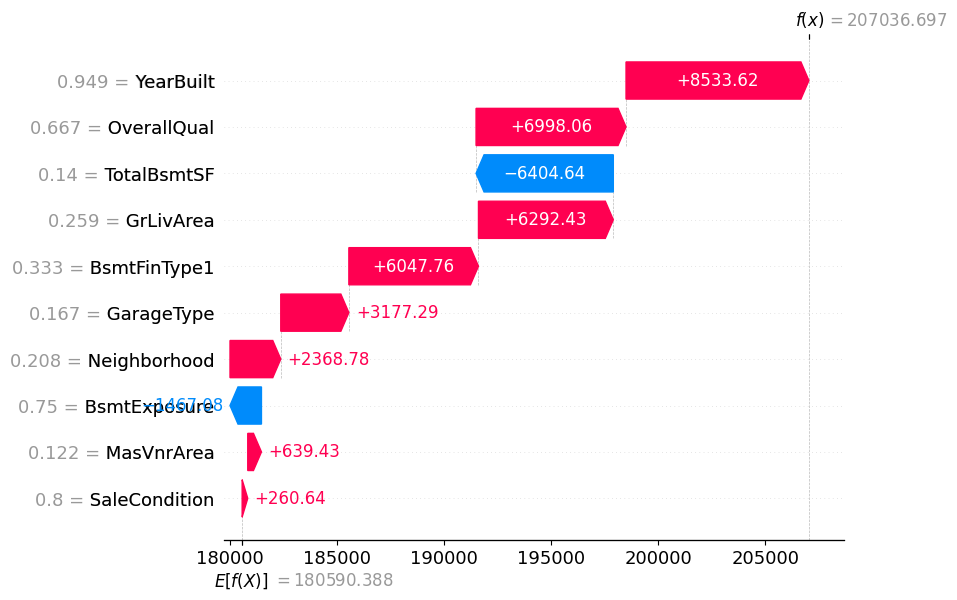

In [ ]:
# Waterfall plot for first observation
shap.plots.waterfall(shap_values_lgbm[0])

Discussion:
The TotalBsmtSF has a negative impact according to this model.

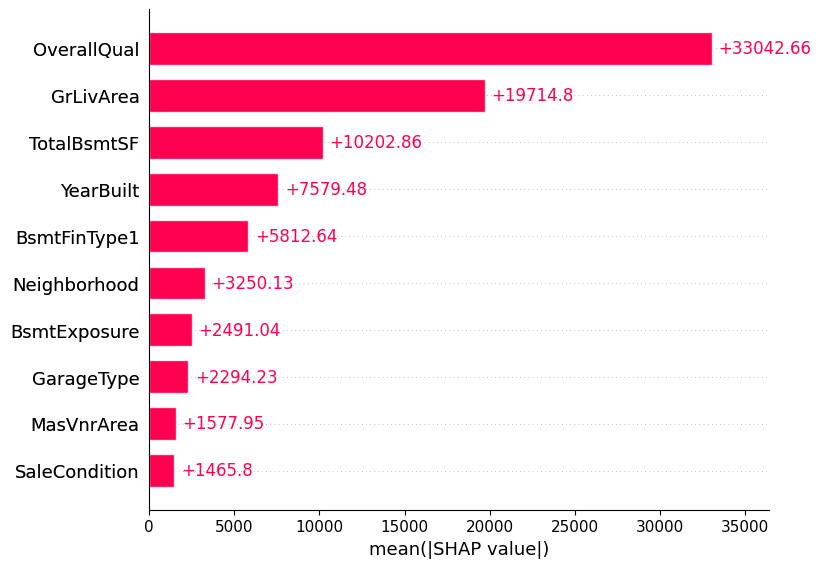

In [ ]:
#Mean SHAP
shap.plots.bar(shap_values_lgbm)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


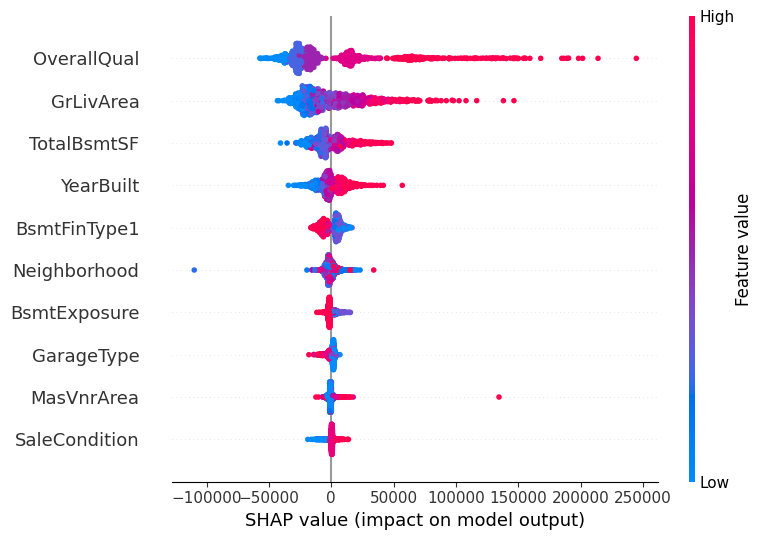

In [ ]:
#Display summary plot
shap.summary_plot(shap_values_lgbm, X_train)

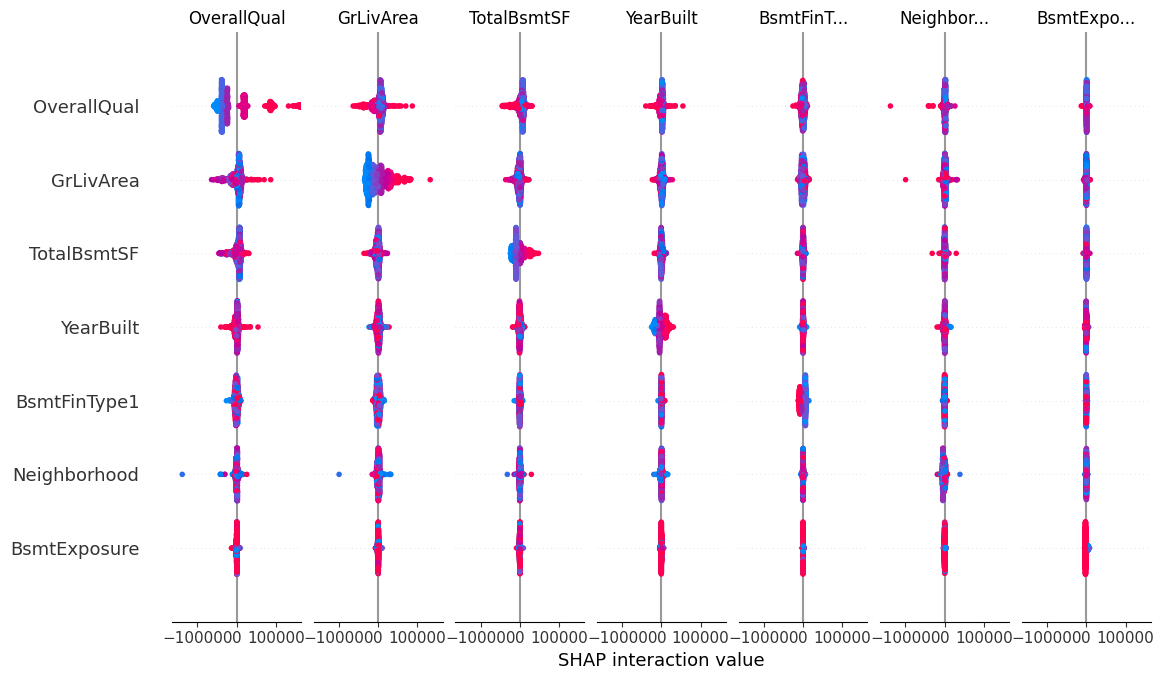

In [ ]:
#Display summary plot
shap.summary_plot(shap_interaction_lgbm, X_train)

##Pickle the models for Steamlit

In [ ]:
# Save LGBM baseline model
pickle.dump(reg_lgbm_baseline, open('lgbm_base.pkl', 'wb'))

# Save LightGBM model optimized via Optuna
pickle.dump(lgbmreg, open('lgbm_optimized.pkl', 'wb'))


**References:**

1. https://towardsdatascience.com/analysing-interactions-with-shap-8c4a2bc11c2a

2. https://towardsdatascience.com/introduction-to-shap-with-python-d27edc23c454

3. https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/

4. https://www.kaggle.com/code/rnepal2/lightgbm-optuna-housing-prices-regression/notebook

5. https://www.kaggle.com/code/rnepal2/lightgbm-optuna-housing-prices-regression/notebook